<a href="https://colab.research.google.com/github/Yuanranzhu/SINN/blob/main/FPU_chain_SINN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!hostname

gnode014.cluster


In [2]:
!nvidia-smi

Thu Feb 22 19:01:42 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 545.23.08              Driver Version: 545.23.08    CUDA Version: 12.3     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA H100 PCIe               Off | 00000000:A8:00.0 Off |                    0 |
| N/A   27C    P0              47W / 350W |      4MiB / 81559MiB |      0%      Default |
|                                         |                      |             Disabled |
+-----------------------------------------+----------------------+--

In [3]:
import itertools as it
import pickle
import torch
import torch.nn as nn
import torch.optim as optim
import torch.fft
import torch.nn.functional as F
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sdeint
from toolbox import (
    make_loss,
    StatLoss,
    SINN,
    FPU
)
import time

In [4]:
torch.cuda.is_available()

True

In [5]:
device = torch.device('cuda')

In [6]:
print(torch.__version__)
print(torch.version.cuda)

2.0.1+cu118
11.8


In [7]:
seed = 1234
torch.set_default_dtype(torch.float)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
np.random.seed(seed)

In [8]:
%%time

######### Generating SINN training data by solving SDE
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from scipy.integrate import quad



###### Parameters 
mag=1              # Magnitude of the coupling
beta=1             # Inverse temperature 
alpha=1            
gamma=1            # Anharmonic potential U(x)=alpha/2* x^2  + gamma/4* x^4
N=100              # Total number of oscillators in the chain 
N_mid=int(N/2)     # Coordinate of the center CG-oscillator 
dt=0.01 
delta_t=0.5
batch = 400
sec_length = 400

Time = 5*delta_t*sec_length
print(Time)
length=int(Time/dt)+1
t = np.linspace(0,Time,length) # define time axis
gap=int(delta_t/dt)
t_store=t[0:-1:gap]



# (q49,q50)
q49_store = np.zeros([t_store.size+1,batch])    
q50_store = np.zeros([t_store.size+1,batch])

q=np.zeros((1,length)) 

p1=np.zeros((N,batch))
q1=np.zeros((N,batch))
p0=np.zeros((N,batch))
q0=np.zeros((N,batch))

# solve SDE

j=1
for i in range(1,length):
    q1=q0+dt*(p0-np.roll(p0,1,axis=0))
    p1=(1-mag*dt)*p0+dt*alpha*(np.roll(q0,-1,axis=0)-q0)+dt*gamma*(np.roll(q0,-1,axis=0)**3-q0**3)+np.sqrt(2*dt*gamma/beta)*np.random.randn(N,batch)
    if i % gap ==0:        
        q49_store[j,:]= np.sum(q1[0:N_mid-1,:], axis=0)
        q50_store[j,:]= np.sum(q1[0:N_mid,:], axis=0)
        j=j+1
    p0=p1
    q0=q1
                                
Toss=int(t_store.size/4)
q49_store=q49_store[Toss:-1,:] 
q50_store=q50_store[Toss:-1,:] 

1000.0
CPU times: user 9min 9s, sys: 10.4 ms, total: 9min 9s
Wall time: 9min 43s


Text(0.5, 1.0, 'Solution of the FPU chain dynamics $q_{49}$ and $q_{50}$')

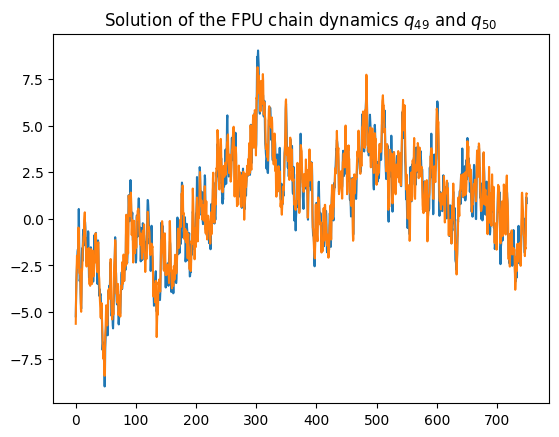

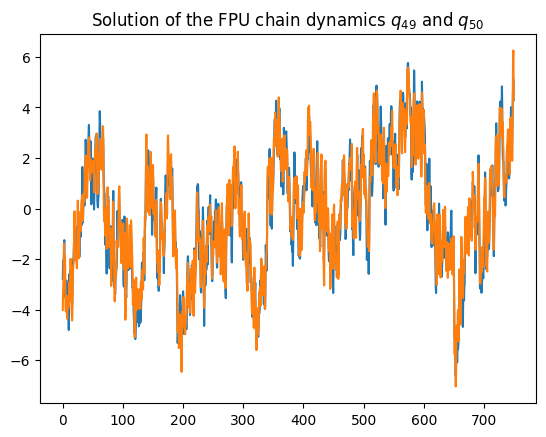

In [9]:
plt.figure(0)
plt.plot(t_store[Toss:]-t_store[Toss],q49_store[:,0])
plt.plot(t_store[Toss:]-t_store[Toss],q50_store[:,0])
plt.title(r"Solution of the FPU chain dynamics $q_{49}$ and $q_{50}$")

plt.figure(1)
plt.plot(t_store[Toss:]-t_store[Toss],q49_store[:,1])
plt.plot(t_store[Toss:]-t_store[Toss],q50_store[:,1])
plt.title(r"Solution of the FPU chain dynamics $q_{49}$ and $q_{50}$")

(400, 400) (400, 400) (400, 400)
(400, 400) (400, 400, 2)


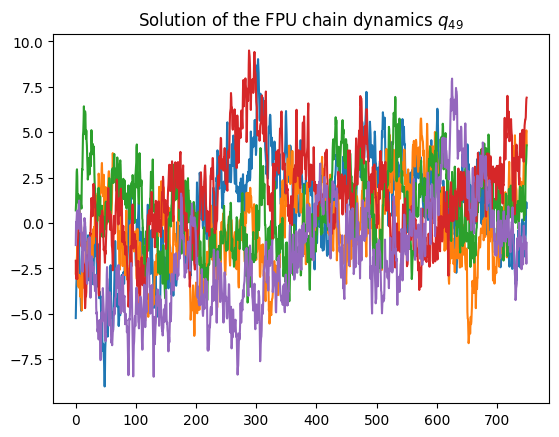

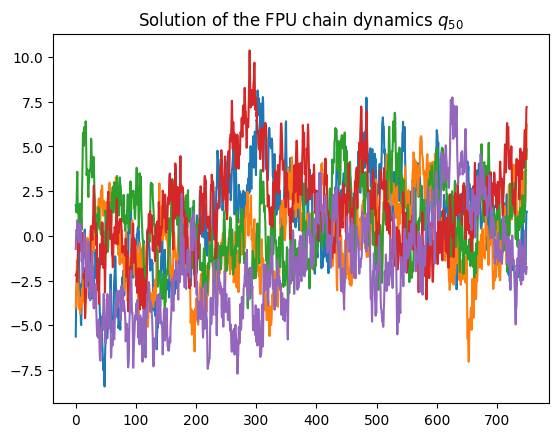

In [10]:
plt.figure(0)
for i in range(5):
    plt.plot(t_store[Toss:]-t_store[Toss],q49_store[:,i])
plt.title(r"Solution of the FPU chain dynamics $q_{49}$")

plt.figure(1)
for i in range(5):
    plt.plot(t_store[Toss:]-t_store[Toss],q50_store[:,i])
plt.title(r"Solution of the FPU chain dynamics $q_{50}$")

###########################################   Construct the sample traj for the LSTM learning 
ini=np.random.randn(sec_length,batch)
Traj49 = q49_store[0:sec_length,:]
Traj50 = q50_store[0:sec_length,:]
print(ini.shape, Traj49.shape, Traj50.shape)

Traj = np.empty((sec_length,batch,2))
Traj[:,:,0] = Traj49
Traj[:,:,1] = Traj50
T=np.arange(len(Traj[:,1]))*delta_t
x=np.linspace(-5,5,sec_length)
print(ini.shape, Traj.shape)

In [11]:
# Reformulating data into Torch tensors 
# Input of SINN should be of the form (seq_len, batch, input_size)

ini = np.random.randn(2*sec_length,2*batch).astype(np.float32) 
input = torch.from_numpy(ini.reshape(2*sec_length, batch, 2)).to(device)
batch_validation = batch
val_set = torch.normal(0.0, 1.0, (2*sec_length, batch_validation, 2), device=device)


Traj = Traj.astype(np.float32) 
target = torch.from_numpy(Traj.reshape(sec_length, batch, 2)).to(device)
print('The torch input size is', input.size(), input.dtype)
print('The torch validation size is', val_set.size(), val_set.dtype)
print('The torch target size is', target.size(), target.dtype)

The torch input size is torch.Size([800, 400, 2]) torch.float32
The torch validation size is torch.Size([800, 400, 2]) torch.float32
The torch target size is torch.Size([400, 400, 2]) torch.float32


In [12]:
# Defining Loss functions
LAGS = 400
N = 400
loss_acf_fft = make_loss('acf[fft]', target, lags=LAGS, device=device)
loss_acf_sec_moment = make_loss('acf[fft]', target**2, lags=LAGS, device=device)
loss_acf_bruteforce = make_loss('acf[bruteforce]', target, lags=LAGS, device=device)
loss_acf_randbrute = make_loss('acf[randombrute]', target, lags=LAGS, sample_lags=20, device=device)

loss_ccf_fft = make_loss('ccf[fft]', target, lags=LAGS, device=device)
loss_ccf_sec_moment = make_loss('ccf[fft]', target**2, lags=LAGS, device=device)
loss_ccf_bruteforce = make_loss('ccf[bruteforce]', target, lags=LAGS, device=device)
loss_ccf_randbrute = make_loss('ccf[randombrute]', target, lags=LAGS, sample_lags=20, device=device)

loss_pdf_empirical1 = make_loss('pdf', target, lower=-5, upper=5, n=N, bw=None, device=device)
loss_pdf_empirical2 = make_loss('pdf6', target, lower=-5, upper=5, n=N, bw=None, device=device)
loss_pdf_empirical2D = make_loss('pdf2D', target, lower=-5, upper=5, n=N, bw=None, device=device)

torch.Size([400, 2])


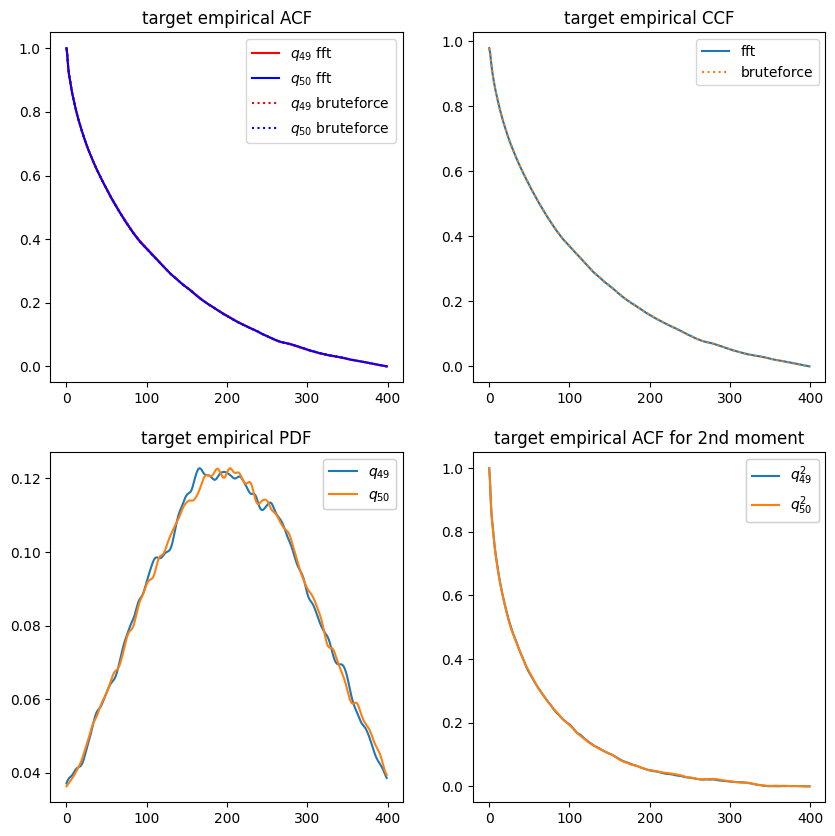

In [13]:
# Plotting target ACFs and PDF
fig, axs = plt.subplots(2, 2, figsize=(10, 10))
axs[0,0].plot(loss_acf_fft._target.cpu()[...,0],'r', label=r'$q_{49}$ fft')
axs[0,0].plot(loss_acf_fft._target.cpu()[...,1],'b', label=r'$q_{50}$ fft')
axs[0,0].plot(loss_acf_bruteforce._target.cpu()[...,0],'r:', label= r'$q_{49}$ bruteforce')
axs[0,0].plot(loss_acf_bruteforce._target.cpu()[...,1], 'b:', label=r'$q_{50}$ bruteforce')
axs[0,0].legend()
axs[0,0].set_title('target empirical ACF')

axs[0,1].plot(loss_ccf_fft._target.cpu()[...,1:3], label='fft')
axs[0,1].plot(loss_ccf_bruteforce._target.cpu()[...,1:3],':',label='bruteforce')
# legend2 = axs[0,1].legend(iter(bf), ('q bf', 'p bf'), loc=1)
# axs[0,1].add_artist(legend2)
axs[0,1].legend()
axs[0,1].set_title('target empirical CCF')

x_grid=-np.linspace(-5,5,num=sec_length)
pdf = axs[1,0].plot(loss_pdf_empirical1._target.cpu())
legend3 = axs[1,0].legend(iter(pdf), (r'$q_{49}$',r'$q_{50}$'), loc=1)
axs[1,0].add_artist(legend3)
axs[1,0].set_title('target empirical PDF')


print(loss_acf_sec_moment._target.cpu().size())
sec_moment = axs[1,1].plot(loss_acf_sec_moment._target.cpu())
legend4 = axs[1,1].legend(iter(sec_moment), (r'$q_{49}^2$',r'$q_{50}^2$'),loc=1)
axs[1,1].set_title('target empirical ACF for 2nd moment')
axs[1,1].add_artist(legend4)

plt.show()

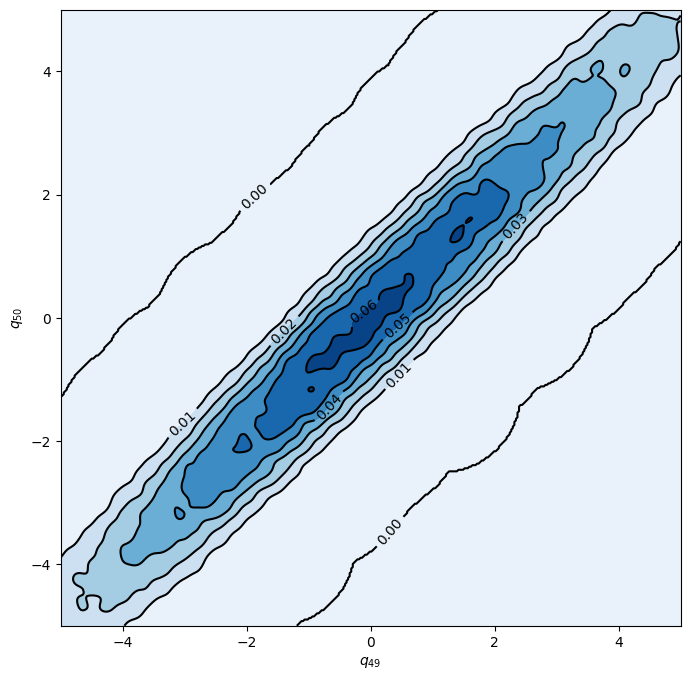

In [14]:
xmin, xmax = -5, 5
ymin, ymax = -5, 5

xx, yy = np.mgrid[xmin:xmax:400j, ymin:ymax:400j]
fig = plt.figure(figsize=(8, 8))
ax = fig.gca()
ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin, ymax)

# Contourf plot
cfset = ax.contourf(xx, yy, loss_pdf_empirical2D._target.cpu(), cmap='Blues')
## Or kernel density estimate plot instead of the contourf plot

# Contour plot
cset = ax.contour(xx, yy, loss_pdf_empirical2D._target.cpu(), colors='k')
# Label plot
ax.clabel(cset, inline=1, fontsize=10)
ax.set_xlabel(r'$q_{49}$')
ax.set_ylabel(r'$q_{50}$')

plt.show()

Text(0.5, 1.0, 'target empirical PDF')

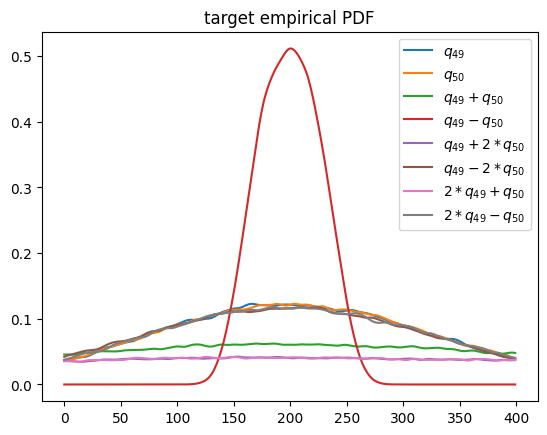

In [15]:
x_grid=-np.linspace(-5,5,num=sec_length)
plt.plot(loss_pdf_empirical1._target.cpu()[...,0],label=r'$q_{49}$')
plt.plot(loss_pdf_empirical1._target.cpu()[...,1],label=r'$q_{50}$')
plt.plot(loss_pdf_empirical2._target.cpu()[...,0],label=r'$q_{49}+q_{50}$')
plt.plot(loss_pdf_empirical2._target.cpu()[...,1],label=r'$q_{49}-q_{50}$')
plt.plot(loss_pdf_empirical2._target.cpu()[...,2],label=r'$q_{49}+2*q_{50}$')
plt.plot(loss_pdf_empirical2._target.cpu()[...,3],label=r'$q_{49}-2*q_{50}$')
plt.plot(loss_pdf_empirical2._target.cpu()[...,4],label=r'$2*q_{49}+q_{50}$')
plt.plot(loss_pdf_empirical2._target.cpu()[...,5],label=r'$2*q_{49}-q_{50}$')
plt.legend()
plt.title('target empirical PDF')

In [16]:
class Model:
    def __init__(self, net):

        self.x_acf_s = None
        self.x_ccf_s = None
        self.x_pdf_s = None
        self.x_pdf2_s = None
        self.x_acf2_s = None
        self.s_collect = []

        self.net = net

        self.T_error=[]
        self.V_error=[]
        self.T_ccf=[]
        self.V_ccf=[]
        self.T_pdf=[]
        self.V_pdf=[]
        self.T_pdf2=[]
        self.V_pdf2=[]
        self.T_acf=[]
        self.V_acf=[]
        self.T_acf2=[]
        self.V_acf2=[]
        self.Step=[]
        self.iter = 0
        self.time = 0

    def train_U(self, x):
        return self.net(x)

    def predict_U(self, x):
        return self.train_U(x)

    def likelihood_loss(self, loss_acf, loss_ccf, loss_pdf, loss_pdf2, loss_acf2):
        loss = torch.reciprocal(2. * self.x_acf_s ** 2) * loss_acf.detach()      \
               + torch.reciprocal(2. * self.x_ccf_s ** 2) * loss_ccf.detach()    \
               + torch.reciprocal(2. * self.x_pdf_s ** 2) * loss_pdf.detach()    \
               + torch.reciprocal(2. * self.x_pdf2_s ** 2) * loss_pdf2.detach()  \
               + torch.reciprocal(2. * self.x_acf2_s ** 2) * loss_acf2.detach()  \
               + torch.log(self.x_acf_s * self.x_ccf_s * self.x_pdf_s * self.x_pdf2_s * self.x_acf2_s)
        return loss

    def true_loss(self, loss_acf, loss_ccf, loss_pdf, loss_pdf2, loss_acf2):
        return torch.reciprocal(2. * self.x_acf_s.detach() ** 2) * loss_acf + torch.reciprocal(2. * self.x_ccf_s.detach() ** 2) * loss_ccf + torch.reciprocal(2. * self.x_pdf_s.detach() ** 2) * loss_pdf + torch.reciprocal(2. * self.x_pdf2_s.detach() ** 2) * loss_pdf2 + torch.reciprocal(2. * self.x_acf2_s.detach() ** 2) * loss_acf2


    def run_baseline(self):
        optimizer_adam = optim.Adam(self.net.parameters(), lr=1e-3)
        for step in range(20000):
            optimizer_adam.zero_grad()
            ini = np.random.randn(2*sec_length, batch*self.net.lstm.input_size).astype(np.float32) 
            input = torch.from_numpy(ini.reshape(2*sec_length, batch, self.net.lstm.input_size)).to(device)
            prediction, _ = self.train_U(input)
            prediction = prediction[-LAGS:,:,:]
            loss = self.true_loss(loss_acf_fft(prediction), loss_ccf_fft(prediction),loss_pdf_empirical1(prediction),loss_pdf_empirical2(prediction),loss_acf_sec_moment(prediction**2))
            loss.backward()
            optimizer_adam.step()
            self.iter += 1
            if step % 50 == 0: 
                with torch.no_grad():
                    loss = loss_acf_fft(prediction)+loss_ccf_fft(prediction)+loss_pdf_empirical1(prediction)+loss_pdf_empirical2(prediction)+loss_acf_sec_moment(prediction**2)
                    pred_val, _ = self.predict_U(val_set)
                    pred_val = pred_val[-LAGS:,:,:]
                    loss_val = loss_acf_bruteforce(pred_val)+loss_ccf_bruteforce(pred_val)+ loss_pdf_empirical1(pred_val)+ loss_pdf_empirical2(pred_val) + loss_acf_sec_moment(pred_val**2)
                    acf = loss_acf_bruteforce(pred_val)
                    ccf = loss_ccf_bruteforce(pred_val)
                    pdf = loss_pdf_empirical1(pred_val)
                    pdf2 = loss_pdf_empirical2(pred_val)
                    acf_sec_moment = loss_acf_sec_moment(pred_val**2)
                    print('[%d]-th step loss: %.4f, %.4f, acf: %.5f, ccf: %.5f, pdf: %.5f, pdf2: %.5f, acf2: %.5f' % (step, loss, loss_val, acf, ccf, pdf, pdf2, acf_sec_moment))
                    self.T_acf.append(loss_acf_fft(prediction).detach().cpu().numpy())
                    self.V_acf.append(loss_acf_bruteforce(pred_val).detach().cpu().numpy())
                    self.T_ccf.append(loss_ccf_fft(prediction).detach().cpu().numpy())
                    self.V_ccf.append(loss_ccf_bruteforce(pred_val).detach().cpu().numpy())
                    self.T_pdf.append(loss_pdf_empirical1(prediction).detach().cpu().numpy())
                    self.V_pdf.append(loss_pdf_empirical1(pred_val).detach().cpu().numpy())
                    self.T_pdf2.append(loss_pdf_empirical2(prediction).detach().cpu().numpy())
                    self.V_pdf2.append(loss_pdf_empirical2(pred_val).detach().cpu().numpy())
                    self.T_acf2.append(loss_acf_sec_moment(prediction**2).detach().cpu().numpy())
                    self.V_acf2.append(loss_acf_sec_moment(pred_val**2).detach().cpu().numpy())
                    self.T_error.append(loss.detach().cpu().numpy())
                    self.V_error.append(loss_val.detach().cpu().numpy())
                    self.Step.append(step)
            if loss <=0.0005 and loss_val <=0.0005:
                break

        if loss > 0.0005 or loss_val > 0.0005:
            print ('Training failed')
        print('Training finished')



    def run_AW(self):
        self.x_acf_s = nn.Parameter(self.x_acf_s, requires_grad=True)
        self.x_ccf_s = nn.Parameter(self.x_ccf_s, requires_grad=True)
        self.x_pdf_s = nn.Parameter(self.x_pdf_s, requires_grad=True)
        self.x_pdf2_s = nn.Parameter(self.x_pdf2_s, requires_grad=True)
        self.x_acf2_s = nn.Parameter(self.x_acf2_s, requires_grad=True)


        optimizer_adam = optim.Adam(self.net.parameters(), lr=1e-3)
        optimizer_adam_weight = optim.Adam([self.x_acf_s] + [self.x_ccf_s] + [self.x_pdf_s] + [self.x_pdf2_s] + [self.x_acf2_s],
                                                     lr=1e-3)

        for step in range(20000):
            self.s_collect.append([self.iter, self.x_acf_s.item(), self.x_ccf_s.item(), self.x_pdf_s.item(), self.x_pdf2_s.item(), self.x_acf2_s.item()])

            optimizer_adam.zero_grad()
            ini = np.random.randn(2*sec_length, batch*self.net.lstm.input_size).astype(np.float32) 
            input = torch.from_numpy(ini.reshape(2*sec_length, batch, self.net.lstm.input_size)).to(device)
            prediction, _ = self.train_U(input)
            prediction = prediction[-LAGS:,:,:]
            loss = self.true_loss(loss_acf_fft(prediction), loss_ccf_fft(prediction),loss_pdf_empirical1(prediction),loss_pdf_empirical2(prediction),loss_acf_sec_moment(prediction**2))
            loss.backward()
            optimizer_adam.step()
            self.iter += 1
            if step % 50 == 0: 
                with torch.no_grad():
                    loss = loss_acf_fft(prediction)+loss_ccf_fft(prediction)+loss_pdf_empirical1(prediction)+loss_pdf_empirical2(prediction)+loss_acf_sec_moment(prediction**2)
                    pred_val, _ = self.predict_U(val_set)
                    pred_val = pred_val[-LAGS:,:,:]
                    loss_val = loss_acf_bruteforce(pred_val)+loss_ccf_bruteforce(pred_val)+ loss_pdf_empirical1(pred_val) + loss_pdf_empirical2(pred_val) + loss_acf_sec_moment(pred_val**2)
                    acf = loss_acf_bruteforce(pred_val)
                    ccf = loss_ccf_bruteforce(pred_val)
                    pdf = loss_pdf_empirical1(pred_val)
                    pdf2 = loss_pdf_empirical2(pred_val)
                    acf_sec_moment = loss_acf_sec_moment(pred_val**2)
                    print('[%d]-th step loss: %.4f, %.4f, acf: %.5f, ccf: %.5f, pdf: %.5f, pdf2: %.5f, acf2: %.5f' % (step, loss, loss_val, acf, ccf, pdf, pdf2, acf_sec_moment))
                    self.T_acf.append(loss_acf_fft(prediction).detach().cpu().numpy())
                    self.V_acf.append(loss_acf_bruteforce(pred_val).detach().cpu().numpy())
                    self.T_ccf.append(loss_ccf_fft(prediction).detach().cpu().numpy())
                    self.V_ccf.append(loss_ccf_bruteforce(pred_val).detach().cpu().numpy())
                    self.T_pdf.append(loss_pdf_empirical1(prediction).detach().cpu().numpy())
                    self.V_pdf.append(loss_pdf_empirical1(pred_val).detach().cpu().numpy())
                    self.T_pdf2.append(loss_pdf_empirical2(prediction).detach().cpu().numpy())
                    self.V_pdf2.append(loss_pdf_empirical2(pred_val).detach().cpu().numpy())
                    self.T_acf2.append(loss_acf_sec_moment(prediction**2).detach().cpu().numpy())
                    self.V_acf2.append(loss_acf_sec_moment(pred_val**2).detach().cpu().numpy())
                    self.T_error.append(loss.detach().cpu().numpy())
                    self.V_error.append(loss_val.detach().cpu().numpy())
                    self.Step.append(step)
            if loss <=0.0005 and loss_val <=0.0005:
                break
            optimizer_adam_weight.zero_grad()
            loss = self.likelihood_loss(loss_acf_fft(prediction), loss_ccf_fft(prediction),loss_pdf_empirical1(prediction),loss_pdf_empirical2(prediction),loss_acf_sec_moment(prediction**2))
            loss.backward()
            optimizer_adam_weight.step()
            
        if loss > 0.0005 or loss_val > 0.0005:
            print ('Training failed')
        print('Training finished')


    def train(self):
        self.x_acf_s = torch.tensor(2.).float()
        self.x_ccf_s = torch.tensor(2.).float()
        self.x_pdf_s = torch.tensor(0.2).float()
        self.x_pdf2_s = torch.tensor(0.2).float()
        self.x_acf2_s = torch.tensor(0.2).float()
        start_time = time.time()
        if model_type == 0:
            self.run_baseline()
        elif model_type == 1:
            self.run_AW()
        elapsed = time.time() - start_time
        self.time = elapsed
        print('Training time: %.2f' % elapsed)
        avg_time = elapsed/self.iter
        print('Training time per iteration: %.2f' % avg_time)
        print('Number of Iterations:%d' %self.iter)

In [17]:
### Defining SINN model
net = SINN(2, 75, 4, 2).to(device) # input dimension, hidden size, number of layers, output dimension

In [18]:
model = Model(net=net)

In [19]:
model_type = 1

In [20]:
model.train()

[0]-th step loss: 0.8432, 0.8313, acf: 0.09574, ccf: 0.11258, pdf: 0.29315, pdf2: 0.28995, acf2: 0.03988
[50]-th step loss: 0.1485, 0.1358, acf: 0.04930, ccf: 0.04920, pdf: 0.01131, pdf2: 0.00960, acf2: 0.01635
[100]-th step loss: 0.0354, 0.0689, acf: 0.02662, ccf: 0.02656, pdf: 0.00622, pdf2: 0.00464, acf2: 0.00489
[150]-th step loss: 0.0382, 0.0254, acf: 0.00746, ccf: 0.00745, pdf: 0.00505, pdf2: 0.00390, acf2: 0.00151
[200]-th step loss: 0.0266, 0.0203, acf: 0.00482, ccf: 0.00481, pdf: 0.00356, pdf2: 0.00634, acf2: 0.00072
[250]-th step loss: 0.0303, 0.0282, acf: 0.00905, ccf: 0.00904, pdf: 0.00368, pdf2: 0.00454, acf2: 0.00184
[300]-th step loss: 0.0236, 0.0197, acf: 0.00729, ccf: 0.00729, pdf: 0.00241, pdf2: 0.00187, acf2: 0.00089
[350]-th step loss: 0.0175, 0.0146, acf: 0.00617, ccf: 0.00615, pdf: 0.00095, pdf2: 0.00068, acf2: 0.00063
[400]-th step loss: 0.0297, 0.0310, acf: 0.01472, ccf: 0.01466, pdf: 0.00020, pdf2: 0.00047, acf2: 0.00095
[450]-th step loss: 0.0693, 0.0392, acf:

In [21]:
def draw_loss(model):
    ### Plotting the training and the generalization error
    fig = plt.figure(1)
    ax = fig.add_axes([0.15, 0.15, 0.75, 0.75])
    plt.title("Error plot",fontsize=15) 
    plt.yscale('log')
    plt.plot(model.Step, model.T_error,'r',label='Training error')
    plt.plot(model.Step, model.V_error,'b--',label='Validation error')
#     plt.loglog(model.Step, model.T_error,'r',label='Training error')
#     plt.loglog(model.Step, model.V_error,'b--',label='Validation error')
    plt.xlabel(r'Training times $n$',fontsize=15)
    plt.ylabel(r'$l_1+l_2$',fontsize=15)
    plt.legend(frameon=False,fontsize=15)

In [22]:
def draw_errors(model):
    ### Plotting the training and the generalization error
    fig = plt.figure(1)
    ax = fig.add_axes([0.15, 0.15, 0.75, 0.75])
    plt.title("Error plot for loss functions w/o coeff",fontsize=15)
    plt.yscale('log')
    plt.plot(model.Step, model.T_error,'k',label='Training error')
    plt.plot(model.Step, model.V_error,'k--')
    plt.plot(model.Step, model.T_acf,'r',label='acf error')
    plt.plot(model.Step, model.V_acf,'r--')
    plt.plot(model.Step, model.T_ccf,'b',label='ccf error')
    plt.plot(model.Step, model.V_ccf,'b--')
    plt.plot(model.Step, model.T_pdf,'y',label='pdf error')
    plt.plot(model.Step, model.V_pdf,'y--')
    plt.plot(model.Step, model.T_pdf2,'m',label='pdf2 error')
    plt.plot(model.Step, model.V_pdf2,'m--')
    plt.plot(model.Step, model.T_acf2,'g',label='acf2 error')
    plt.plot(model.Step, model.V_acf2,'g--')
    
#     plt.loglog(model.Step, model.T_error,'k',label='Training error')
#     plt.loglog(model.Step, model.V_error,'k--')
#     plt.loglog(model.Step, model.T_acf,'r',label='acf error')
#     plt.loglog(model.Step, model.V_acf,'r--')
#     plt.loglog(model.Step, model.T_ccf,'b',label='ccf error')
#     plt.loglog(model.Step, model.V_ccf,'b--')
#     plt.loglog(model.Step, model.T_pdf,'y',label='pdf error')
#     plt.loglog(model.Step, model.V_pdf,'y--')
#     plt.loglog(model.Step, model.T_pdf2,'m',label='pdf2 error')
#     plt.loglog(model.Step, model.V_pdf2,'m--')
#     plt.loglog(model.Step, model.T_acf2,'g',label='acf2 error')
#     plt.loglog(model.Step, model.V_acf2,'g--')
    plt.xlabel(r'Training times $n$',fontsize=15)
    plt.ylabel(r'$l_1+l_2$',fontsize=15)
    plt.legend(frameon=False,fontsize=15, bbox_to_anchor=(1.1, 1.05))

In [23]:
def draw_adaptive_w(model):
    s_collect = np.array(model.s_collect)
    np.savetxt('s_RAM-AW.npy', s_collect)
#     plt.yscale('log')
    plt.plot(s_collect[:, 0], s_collect[:, 1], 'r-', label=r'$\epsilon_{acf}$')
    plt.plot(s_collect[:, 0], s_collect[:, 2], 'b-', label='$\epsilon_{ccf}$')
    plt.plot(s_collect[:, 0], s_collect[:, 3], 'y-', label='$\epsilon_{pdf}$')
    plt.plot(s_collect[:, 0], s_collect[:, 4], 'm-', label='$\epsilon_{pdf2}$')
    plt.plot(s_collect[:, 0], s_collect[:, 5], 'g-', label='$\epsilon_{acf2}$')
    plt.xlabel('$Iters$')
    plt.ylabel('$s$')
#     plt.xscale('log')
    plt.legend()
#     plt.savefig('2dpossion_S_RAM-AW.pdf')
    plt.show()

In [24]:
def draw_epoch_w(model):
    s_collect = np.array(model.s_collect)
    np.savetxt('s_RAM-AW.npy', s_collect)
    plt.yscale('log')
    plt.plot(s_collect[:, 0], np.reciprocal(2. * s_collect[:, 1]**2), 'r-', label=r'$\frac{1}{2\epsilon_{acf}^2}$')
    plt.plot(s_collect[:, 0], np.reciprocal(2. * s_collect[:, 2]**2), 'b-', label=r'$\frac{1}{2\epsilon_{ccf}^2}$')
    plt.plot(s_collect[:, 0], np.reciprocal(2. * s_collect[:, 3]**2), 'y-', label=r'$\frac{1}{2\epsilon_{pdf}^2}$')
    plt.plot(s_collect[:, 0], np.reciprocal(2. * s_collect[:, 4]**2), 'm-', label=r'$\frac{1}{2\epsilon_{pdf2}^2}$')
    plt.plot(s_collect[:, 0], np.reciprocal(2. * s_collect[:, 5]**2), 'g-', label=r'$\frac{1}{2\epsilon_{acf2}^2}$')
    plt.xlabel('$Iters$')
    plt.ylabel('$\omega$')
    plt.legend()
#     plt.savefig('2dpossion_S_RAM-AW.pdf')
    plt.show()

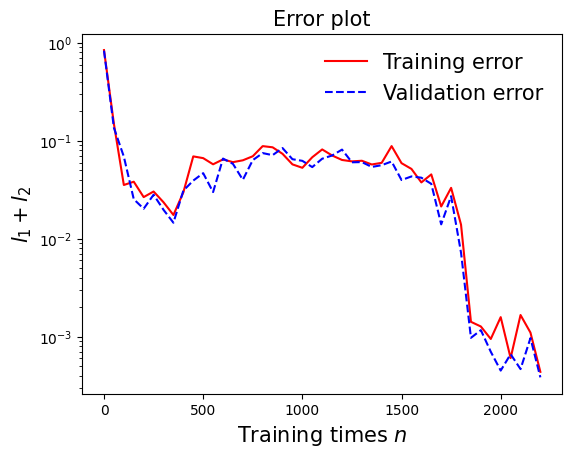

In [25]:
draw_loss(model)

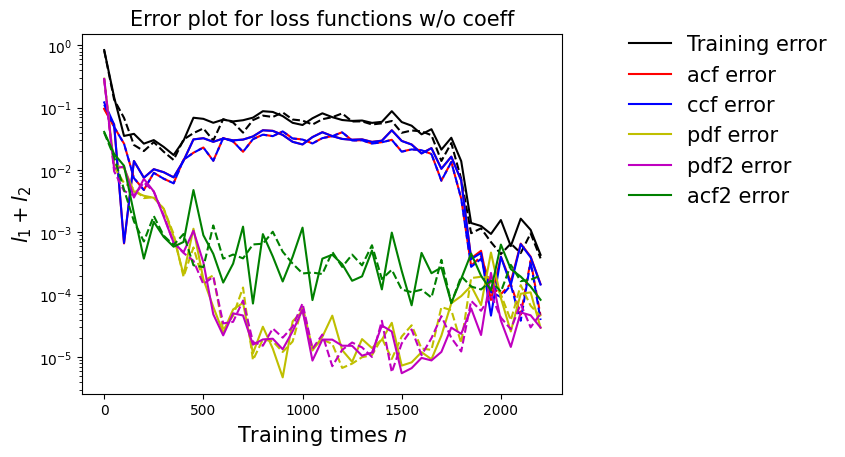

In [26]:
draw_errors(model)

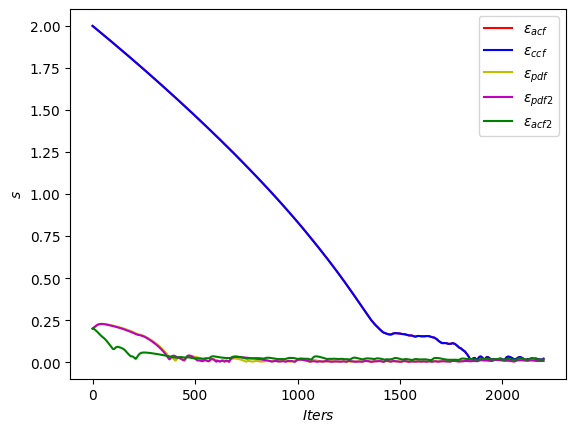

In [27]:
draw_adaptive_w(model)

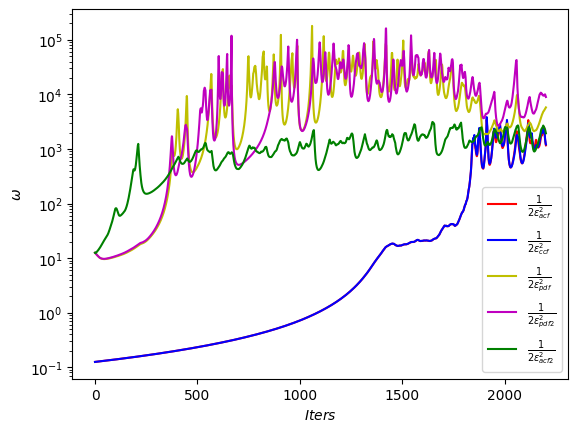

In [28]:
draw_epoch_w(model)

## Test 1: plot the sample path generated by SINN and the exact sample path 

In [29]:
def test1(model):
    ran_input=torch.randn(input.size(),dtype=input.dtype,layout=input.layout, device=input.device)
    Pred,_= model.predict_U(ran_input)
    prediction=Pred[-sec_length:,:,:].detach().cpu().numpy().reshape(sec_length, batch, 2)
    # Test 1: plot the sample path generated by SINN and the exact sample path 
    skip = 0

    fig = plt.figure(0)
    plt.title("MD trajectories",fontsize=15) 
    plt.plot(T[skip:]-T[skip], Traj[skip:, 0])
    plt.xlabel(r'$t$',fontsize=15)
    plt.ylabel(r'$\tilde{q}_1(t)$ and $\tilde{q}_2(t)$',fontsize=15)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15) 


    fig = plt.figure(1)
    plt.title("SINN trajectories",fontsize=15)    
    plt.plot(T[skip:]-T[skip], prediction[skip:, 0])
    plt.xlabel(r'$t$',fontsize=15)
    plt.ylabel(r'$q_1(t)$ and $q_2(t)$',fontsize=15)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)

## Test 2: plot the CCF of the sample path generated by the SINN and the exact CCF

In [30]:
def test2(model):
    ran_input=torch.randn(input.size(),dtype=input.dtype,layout=input.layout, device=input.device)
    Pred,_= model.predict_U(ran_input)
    
    # Test 2: plot the CCF of the sample path generated by the SINN and the exact CCF  
    acf_p=StatLoss.acf(Pred[-sec_length:,:,:])
    acf_t=StatLoss.acf(target)
    corr_p1=acf_p.detach().cpu().numpy()
    corr_t1=acf_t.detach().cpu().numpy()
    ccf_p=StatLoss.ccf(Pred[-sec_length:,:,:])
    ccf_t=StatLoss.ccf(target)
    corr_p2=ccf_p.detach().cpu().numpy()
    corr_t2=ccf_t.detach().cpu().numpy()
    
    fig = plt.figure(0)
    ax = fig.add_axes([0.15, 0.15, 0.75, 0.75])
    plt.title(r'Normalized ACF of $\tilde{q}_1$',fontsize=15)    
    plt.plot(T, corr_t1[...,0],'r',label='Exact')        # correlation function of the target 
    plt.plot(T, corr_p1[...,0], 'b--',label='SINN')        # Correlation function after the training      # Correlation function after the training 
    plt.xlabel(r'$t$',fontsize=15)
    plt.ylabel(r'$C(t)/C(0)$',fontsize=15)
    plt.xticks(fontsize=15)
#     plt.xlim(0,T[-1])
    plt.yticks([-0.2,0,0.2,0.4,0.6,0.8,1.0],fontsize=15)
    plt.legend()
    
    fig = plt.figure(1)
    ax = fig.add_axes([0.15, 0.15, 0.75, 0.75])
    plt.title(r'Normalized ACF of $\tilde{q}_2$',fontsize=15)          
    plt.plot(T, corr_t1[...,-1],'r',label='Exact')        # correlation function of the target 
    plt.plot(T, corr_p1[...,-1], 'b--',label='SINN')     # Correlation function after the training      # Correlation function after the training 
    plt.xlabel(r'$t$',fontsize=15)
    plt.ylabel(r'$C(t)/C(0)$',fontsize=15)
    plt.xticks(fontsize=15)
#     plt.xlim(0,T[-1])
    plt.yticks([-0.2,0,0.2,0.4,0.6,0.8,1.0],fontsize=15)
    plt.legend()
    
    fig = plt.figure(2)
    ax = fig.add_axes([0.15, 0.15, 0.75, 0.75])
    plt.title(r'Normalized CCF',fontsize=15)    
    plt.plot(T, corr_t2[:,:],'r')        # correlation function of the target 
    plt.plot(T, corr_p2[:,:], 'b--')        # Correlation function after the training      # Correlation function after the training 
    plt.xlabel(r'$t$',fontsize=15)
    plt.ylabel(r'$C(t)/C(0)$',fontsize=15)
    plt.xticks(fontsize=15)
#     plt.ylim(-0.05,0.05)

## Test 3: plot the PDF of the sample path generated by SINN and the exact PDF  

In [31]:
def test3(model):
    ran_input=torch.randn(input.size(),dtype=input.dtype,layout=input.layout, device=input.device)
    Pred,_= model.predict_U(ran_input)
    
    # Test 3: plot the PDF of the sample path generated by SINN and the exact PDF  
    rho_data =  StatLoss.gauss_kde(target, -5, 5, 400, None).cpu()
    rho_input = StatLoss.gauss_kde(ran_input, -5, 5, 400, None).cpu()
    rho_prediction = StatLoss.gauss_kde(Pred[-sec_length:,:,:].detach(), -5, 5, 400,None).cpu()
    
    rho_data2 =  StatLoss.gauss_kde6(target, -5, 5, 400, None).cpu()
    rho_prediction2 = StatLoss.gauss_kde6(Pred[-sec_length:,:,:].detach(), -5, 5, 400,None).cpu()


    x=np.linspace(-5, 5, 400)
    fig = plt.figure(0)
    ax = fig.add_axes([0.15, 0.15, 0.75, 0.75])
    plt.title(r"Equilibrium probability density function",fontsize=15)    
    plt.plot(x, rho_data.numpy()[...,0],label=r'Exact PDF of $q_{49}$')    # target PDF
    plt.plot(x, rho_data.numpy()[...,1],label=r'Exact PDF of $q_{50}$')    # target PDF
    plt.plot(x, rho_input.numpy(), 'b--', label=r'PDF of the input')     # PDF of the input
    plt.plot(x, rho_prediction.numpy()[...,0], ':',label=r'PDF of the output $q_{49}$')  # PDF after the training 
    plt.plot(x, rho_prediction.numpy()[...,1], ':',label=r'PDF of the output $q_{50}$')  # PDF after the training 
    plt.xlim(-5,5)
    plt.ylim(0,0.6)
    plt.xlabel(r'$x$',fontsize=15)
    plt.ylabel(r'$\rho(x)$',fontsize=15)
    plt.legend(frameon=False,fontsize=10)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    
    
    fig = plt.figure(1)
    ax = fig.add_axes([0.15, 0.15, 0.75, 0.75])
    plt.title(r"Equilibrium probability density function of sum and diff",fontsize=15)    
    plt.plot(x, rho_data2.numpy()[...,0],label=r'Exact PDF of $q_{49}+q_{50}$')    # target PDF
    plt.plot(x, rho_data2.numpy()[...,1],label=r'Exact PDF of $q_{49}-q_{50}$')    # target PDF
    plt.plot(x, rho_input.numpy(), 'b--', label=r'PDF of the input')     # PDF of the input
    plt.plot(x, rho_prediction2.numpy()[...,0], ':',label=r'PDF of the output $q_{49}+q_{50}$')  # PDF after the training 
    plt.plot(x, rho_prediction2.numpy()[...,1], ':',label=r'PDF of the output $q_{49}-q_{50}$')  # PDF after the training 
    plt.xlim(-5,5)
    plt.ylim(0,0.6)
    plt.xlabel(r'$x$',fontsize=15)
    plt.ylabel(r'$\rho(x)$',fontsize=15)
    plt.legend(frameon=False,fontsize=10)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    
    fig = plt.figure(2)
    ax = fig.add_axes([0.15, 0.15, 0.75, 0.75])
    plt.title(r"Equilibrium probability density function of sum and diff",fontsize=15)    
    plt.plot(x, rho_data2.numpy()[...,2],label=r'Exact PDF of $q_{49}+2q_{50}$')    # target PDF
    plt.plot(x, rho_data2.numpy()[...,3],label=r'Exact PDF of $q_{49}-2q_{50}$')    # target PDF
    plt.plot(x, rho_input.numpy(), 'b--', label=r'PDF of the input')     # PDF of the input
    plt.plot(x, rho_prediction2.numpy()[...,2], ':',label=r'PDF of the output $q_{49}+2\tilde{q}_2$')  # PDF after the training 
    plt.plot(x, rho_prediction2.numpy()[...,3], ':',label=r'PDF of the output $q_{49}-2\tilde{q}_2$')  # PDF after the training 
    plt.xlim(-5,5)
    plt.ylim(0,0.6)
    plt.xlabel(r'$x$',fontsize=15)
    plt.ylabel(r'$\rho(x)$',fontsize=15)
    plt.legend(frameon=False,fontsize=10)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    
    fig = plt.figure(3)
    ax = fig.add_axes([0.15, 0.15, 0.75, 0.75])
    plt.title(r"Equilibrium probability density function of sum and diff",fontsize=15)    
    plt.plot(x, rho_data2.numpy()[...,4],label=r'Exact PDF of $2q_{49}+\tilde{q}_2$')    # target PDF
    plt.plot(x, rho_data2.numpy()[...,5],label=r'Exact PDF of $2q_{49}-\tilde{q}_2$')    # target PDF
    plt.plot(x, rho_input.numpy(), 'b--', label=r'PDF of the input')     # PDF of the input
    plt.plot(x, rho_prediction2.numpy()[...,4], ':',label=r'PDF of the output $2q_{49}+\tilde{q}_2$')  # PDF after the training 
    plt.plot(x, rho_prediction2.numpy()[...,5], ':',label=r'PDF of the output $2q_{49}-\tilde{q}_2$')  # PDF after the training 
    plt.xlim(-5,5)
    plt.ylim(0,0.6)
    plt.xlabel(r'$x$',fontsize=15)
    plt.ylabel(r'$\rho(x)$',fontsize=15)
    plt.legend(frameon=False,fontsize=10)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)

## Test 4: Comparing the higher-order ACF

In [32]:
def test4(model):
    ran_input=torch.randn(input.size(),dtype=input.dtype,layout=input.layout, device=input.device)
    Pred,_= model.predict_U(ran_input)
    prediction=Pred[-sec_length:,:,:].detach().cpu().numpy().reshape(sec_length, batch, 2)
    
    # Test 4: Comparing the higher-order ACF
    acf2=StatLoss.acf(target**2)
    pred_norm=torch.from_numpy((prediction).reshape(sec_length, batch,2))
    acf2_app=StatLoss.acf(pred_norm**2)

    
    fig = plt.figure(0)
    ax = fig.add_axes([0.15, 0.15, 0.75, 0.75])
    plt.title(r'Normalized ACF of $q_{49}^2$',fontsize=15)    
    plt.plot(T, acf2.detach().cpu().numpy()[...,0],'r',label='Exact')        # correlation function of the target 
    plt.plot(T, acf2_app.detach().cpu().numpy()[...,0], 'b--',label='SINN')        # Correlation function after the training      # Correlation function after the training 
    plt.xlabel(r'$t$',fontsize=15)
    plt.ylabel(r'$C(t)/C(0)$',fontsize=15)
    plt.xticks(fontsize=15)
    plt.xlim(0,T[-1])
    plt.yticks([-0.2,0,0.2,0.4,0.6,0.8,1.0],fontsize=15)
    plt.legend()
    
    fig = plt.figure(1)
    ax = fig.add_axes([0.15, 0.15, 0.75, 0.75])
    plt.title(r'Normalized ACF of $q_{50}^2$',fontsize=15)          
    plt.plot(T, acf2.detach().cpu().numpy()[...,1],'r',label='Exact')        # correlation function of the target 
    plt.plot(T, acf2_app.detach().cpu().numpy()[...,1], 'b--',label='SINN')     # Correlation function after the training      # Correlation function after the training 
    plt.xlabel(r'$t$',fontsize=15)
    plt.ylabel(r'$C(t)/C(0)$',fontsize=15)
    plt.xticks(fontsize=15)
    plt.xlim(0,T[-1])
    plt.yticks([-0.2,0,0.2,0.4,0.6,0.8,1.0],fontsize=15)
    plt.legend()    

## Test 5: plot the expolation result, i.e. Prediction of the FPU-Langevin dynamics for longer time 

In [33]:
def test5(model):
    # Test 5: plot the expolation result, i.e. Prediction of the FPU-Langevin dynamics for longer time 
    [a,b,c]=input.size()
    skip=20
    scale=10
    burnin=3
    fold=800
    batch_new=50
    ran_input=torch.randn(((scale-burnin)*a,batch_new,c),dtype=input.dtype,layout=input.layout, device=input.device)
    Pred_L, _= model.predict_U(ran_input)
    prediction_ext=Pred_L.detach().cpu().numpy().reshape((scale-burnin)*a, batch_new,2)
    ccf_p=StatLoss.ccf(Pred_L,method='bruteforce')

    LT=np.linspace(0,(scale-burnin)*a*delta_t,num=(scale-burnin)*a+1)
    LT=LT[0:-1]


    fig = plt.figure(0)
    ax = fig.add_axes([0.15, 0.15, 0.75, 0.75])
    plt.title("Short-time trajectories",fontsize=15)
    plt.plot(t_store[Toss:]-t_store[Toss],q49_store[:,0],label='MD simulation')
    plt.plot(LT[skip:]-LT[skip], prediction_ext[skip:, 0, 0],'--',label='SINN simulation')
    plt.xlim([0,80])
    plt.xlabel(r'$t$',fontsize=15)
    plt.ylabel(r'$q_{49}(t)$',fontsize=15)
    plt.legend(frameon=False,fontsize=15)
    plt.yticks([-2,-1,0,1,2],fontsize=15)
    plt.xticks(fontsize=15)



    fig = plt.figure(figsize=(16, 4))
    ax = fig.add_axes([0.15, 0.15, 0.75, 0.75])
    plt.title("Long-time trajectories",fontsize=15)
    plt.plot(t_store[Toss:]-t_store[Toss],q49_store[:,0],label='MD simulation')
    plt.plot(LT[skip:]-LT[skip], prediction_ext[skip:, 0, 0],'--',label='SINN simulation')
    plt.xlim([0,500])
    plt.xlabel(r'$t$',fontsize=15)
    plt.ylabel(r'$q_{49}(t)$',fontsize=15)
    plt.legend(frameon=False,fontsize=15)
    plt.yticks([-2,-1,0,1,2],fontsize=15)
    plt.xticks(fontsize=15)

    fig = plt.figure(2)
    ax = fig.add_axes([0.15, 0.15, 0.75, 0.75])
    plt.title("Short-time trajectories",fontsize=15)
    plt.plot(t_store[Toss:]-t_store[Toss],q50_store[:,0],label='MD simulation')
    plt.plot(LT[skip:]-LT[skip], prediction_ext[skip:, 0, 1],'--',label='SINN simulation')
    plt.xlim([0,80])
    plt.xlabel(r'$t$',fontsize=15)
    plt.ylabel(r'$q_{50}(t)$',fontsize=15)
    plt.legend(frameon=False,fontsize=15)
    plt.yticks([-2,-1,0,1,2],fontsize=15)
    plt.xticks(fontsize=15)



    fig = plt.figure(figsize=(16, 4))
    ax = fig.add_axes([0.15, 0.15, 0.75, 0.75])
    plt.title("Long-time trajectories",fontsize=15)
    plt.plot(t_store[Toss:]-t_store[Toss],q50_store[:,0],label='MD simulation')
    plt.plot(LT[skip:]-LT[skip], prediction_ext[skip:, 0, 1],'--',label='SINN simulation')
    plt.xlim([0,500])
    plt.xlabel(r'$t$',fontsize=15)
    plt.ylabel(r'$q_{50}(t)$',fontsize=15)
    plt.legend(frameon=False,fontsize=15)
    plt.yticks([-2,-1,0,1,2],fontsize=15)
    plt.xticks(fontsize=15)

## Test 6: comparing scatter plots

In [34]:
def test6(model):
    # Test 6: scatter plot of SINN
    ran_input=torch.randn(input.size(),dtype=input.dtype,layout=input.layout, device=input.device)
    Pred,_= model.predict_U(ran_input)
    prediction=Pred[-sec_length:,:,:].detach().cpu().numpy().reshape(sec_length, batch, 2)
    
    fig = plt.figure(0)
    plt.title("MD trajectories",fontsize=15) 
    plt.scatter(Traj[:,:,0], Traj[:,:,1])
    plt.xlabel(r'$q_{49}(t)$',fontsize=15)
    plt.ylabel(r'$q_{50}(t)$',fontsize=15)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15) 


    fig = plt.figure(1)
    plt.title("SINN trajectories",fontsize=15)    
    plt.scatter(prediction[:,:,0],prediction[:,:,1])
    plt.xlabel(r'$q_{49}(t)$',fontsize=15)
    plt.ylabel(r'$q_{50}(t)$',fontsize=15)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)

## Test 7: comparing joint PDF contours

In [35]:
def test7(model):
    # Test 5: scatter plot of SINN
    ran_input=torch.randn(input.size(),dtype=input.dtype,layout=input.layout, device=input.device)
    Pred,_= model.predict_U(ran_input)
    prediction=Pred[-sec_length:,:,:].detach().cpu().numpy().reshape(sec_length, batch, 2)
    
    rho_data =  StatLoss.gauss_kde2D(target, -5, 5, 400, None).cpu()
    rho_prediction = StatLoss.gauss_kde2D(Pred[-sec_length:,:,:].detach(), -5, 5, 400,None).cpu()
    
    fig = plt.figure(0, figsize=(5, 5))
    plt.title("PDF Contours",fontsize=15) 
    xmin, xmax = -5, 5
    ymin, ymax = -5, 5

    xx, yy = np.mgrid[xmin:xmax:400j, ymin:ymax:400j]
    axs[0]  = fig.gca()
    plt.xlim(xmin, xmax)
    plt.ylim(ymin, ymax)
    
    plt.contour(xx,yy,rho_data.numpy(),colors='r')
    plt.contour(xx,yy,rho_prediction.numpy(),colors='b',linestyles='dashed')

    plt.xlabel(r'$q_{49}$')
    plt.ylabel(r'$q_{50}$')

    
    
    fig = plt.figure(1,figsize=(5, 5))
    plt.title("MD trajectories",fontsize=15) 
    xmin, xmax = -5, 5
    ymin, ymax = -5, 5

#     xx, yy = np.mgrid[xmin:xmax:20j, ymin:ymax:20j]
    ax  = fig.gca()
    ax.set_xlim(xmin, xmax)
    ax.set_ylim(ymin, ymax)
    cfset = ax.contourf(xx, yy, rho_data.numpy(), cmap='Blues')
    cset = ax.contour(xx, yy, rho_data.numpy(), colors='k')

    ax.clabel(cset, inline=1, fontsize=10)
    ax.set_xlabel(r'$q_{49}$')
    ax.set_ylabel(r'$q_{50}$')

    
    
    fig = plt.figure(2,figsize=(5, 5))
    plt.title("SINN output",fontsize=15) 
    xmin, xmax = -5, 5
    ymin, ymax = -5, 5

#     xx, yy = np.mgrid[xmin:xmax:20j, ymin:ymax:20j]
    ax  = fig.gca()
    ax.set_xlim(xmin, xmax)
    ax.set_ylim(ymin, ymax)
    cfset = ax.contourf(xx, yy, rho_prediction.numpy(), cmap='Blues')
    cset = ax.contour(xx, yy, rho_prediction.numpy(), colors='k')

    ax.clabel(cset, inline=1, fontsize=10)
    ax.set_xlabel(r'$q_{49}$')
    ax.set_ylabel(r'$q_{50}$')

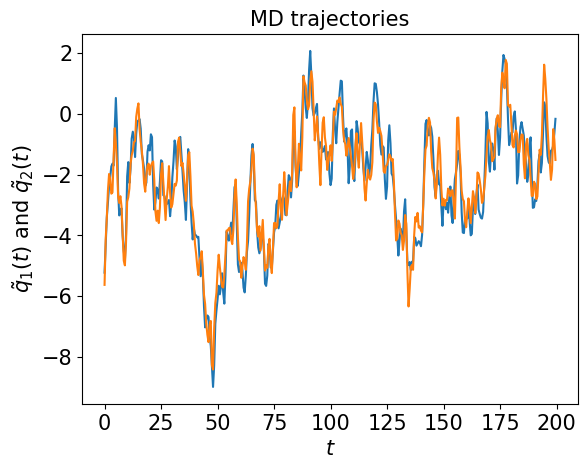

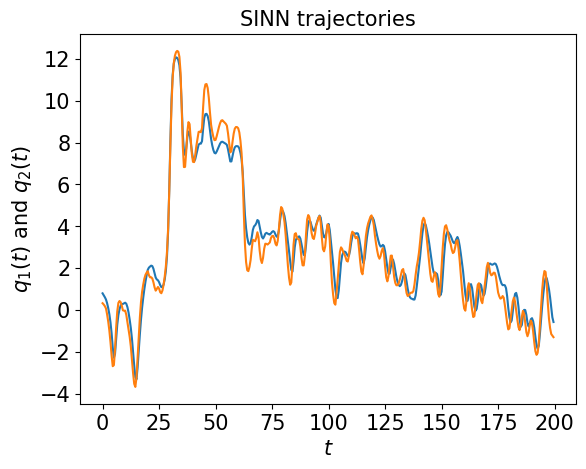

In [36]:
test1(model)

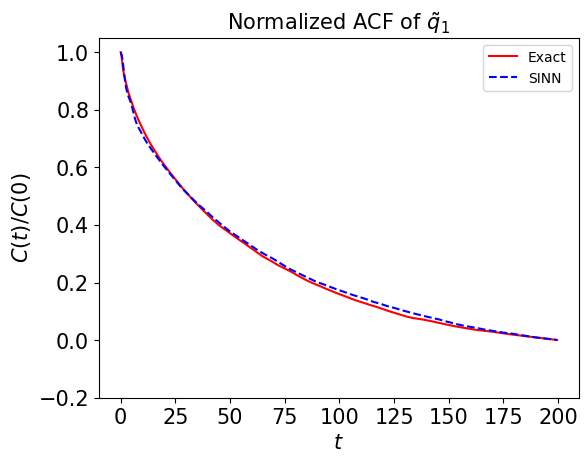

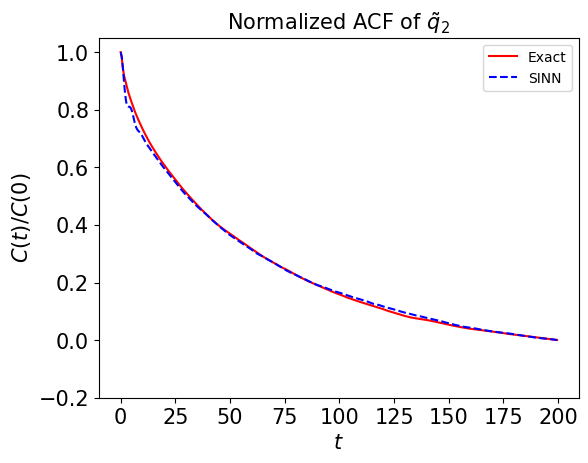

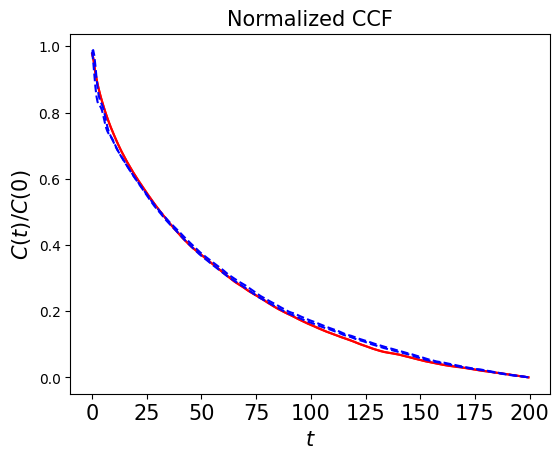

In [37]:
test2(model)

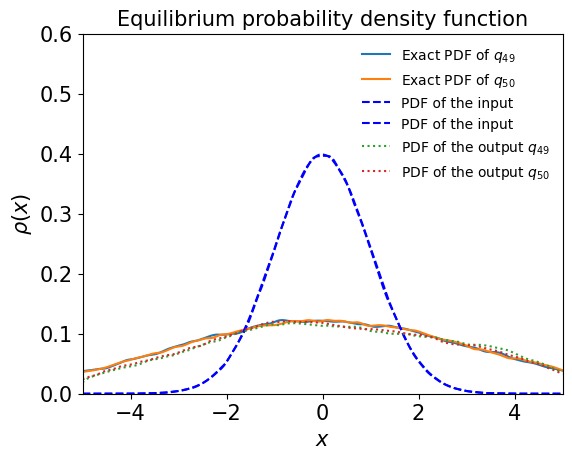

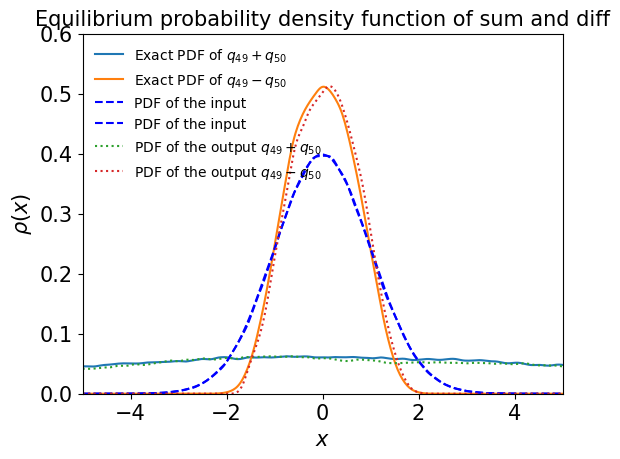

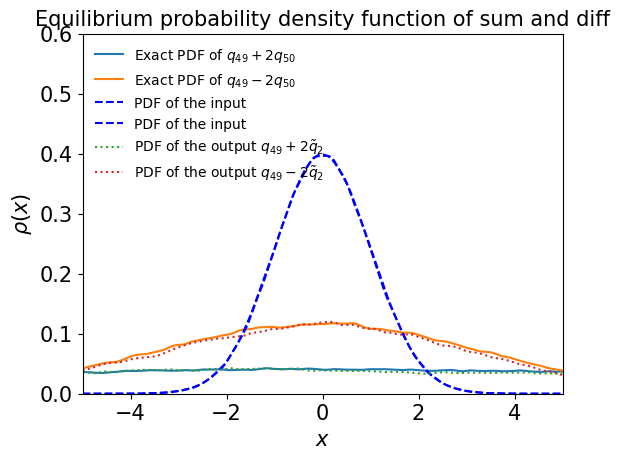

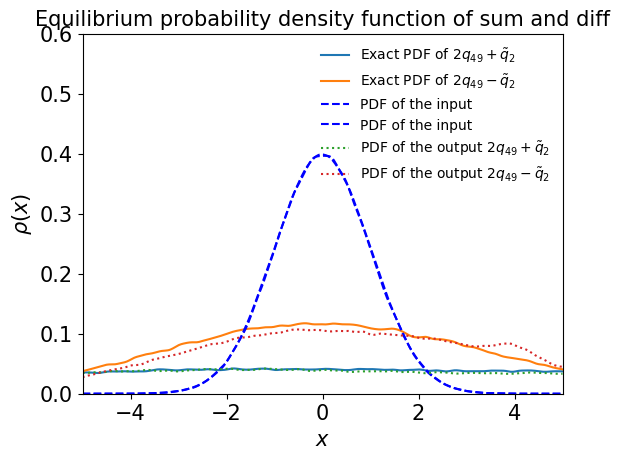

In [38]:
test3(model)

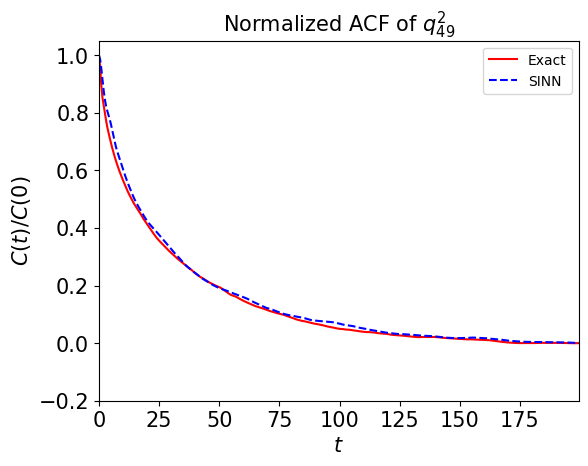

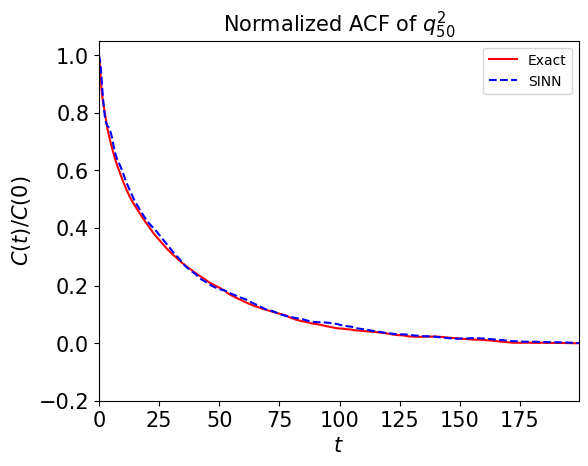

In [39]:
test4(model)

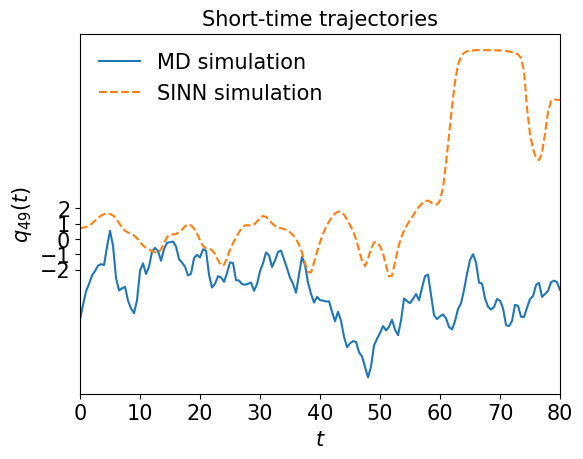

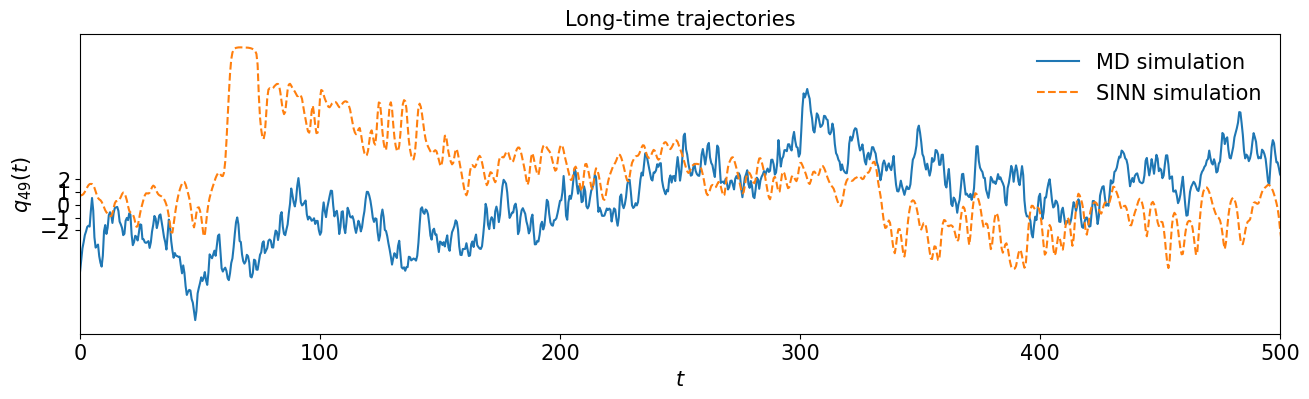

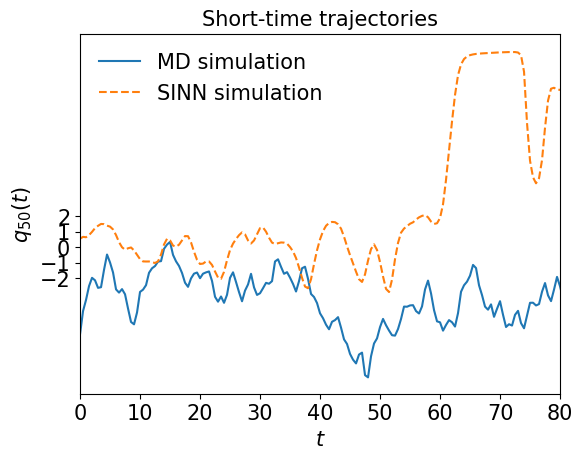

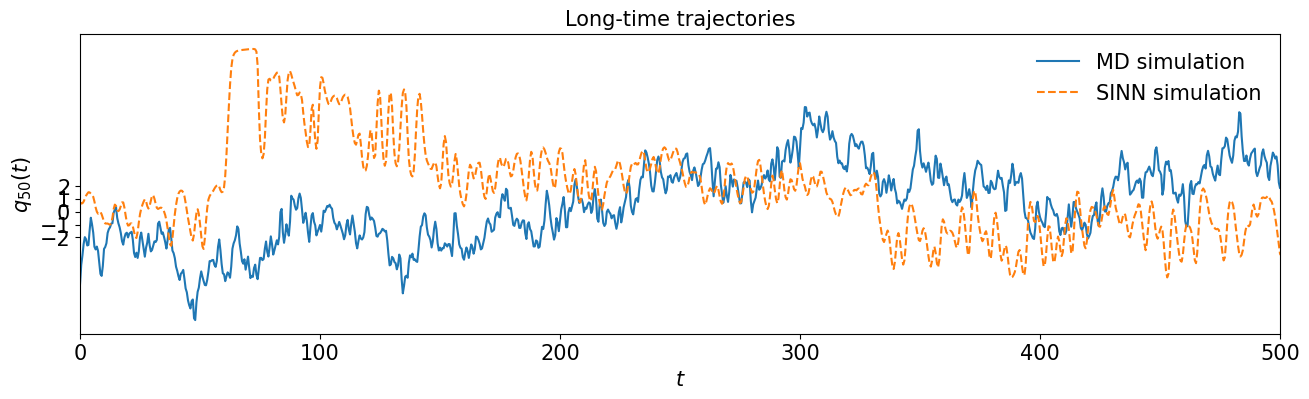

In [40]:
test5(model)

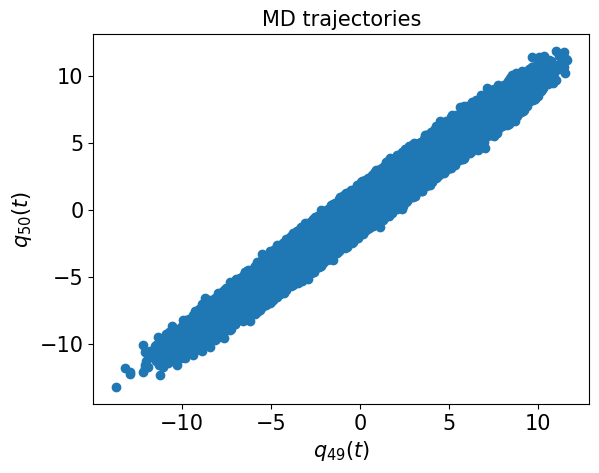

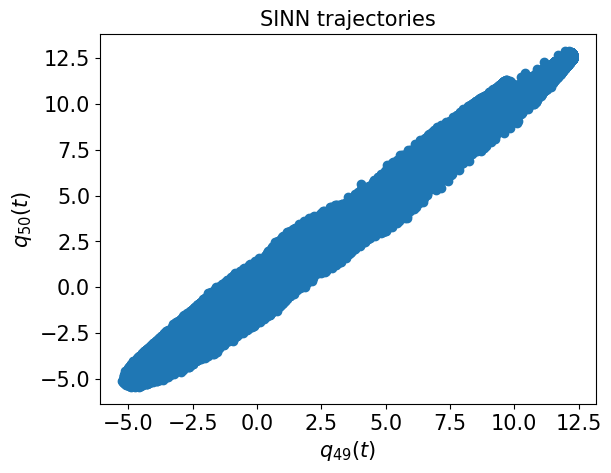

In [41]:
test6(model)

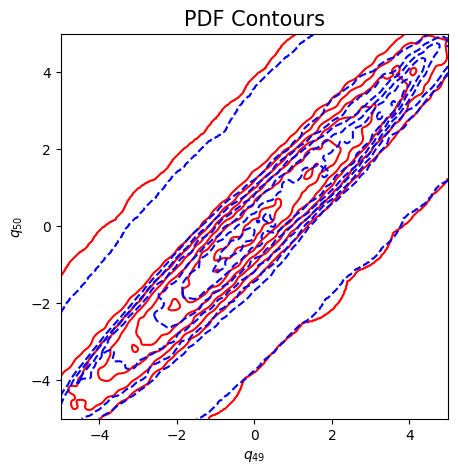

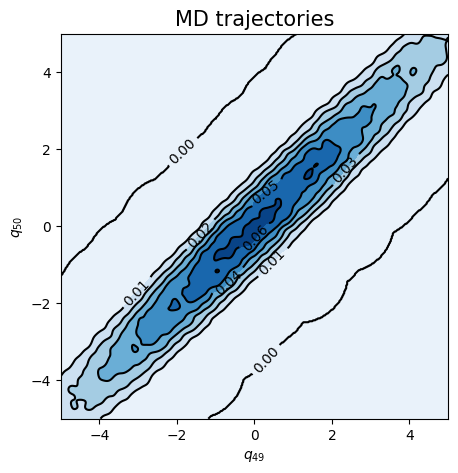

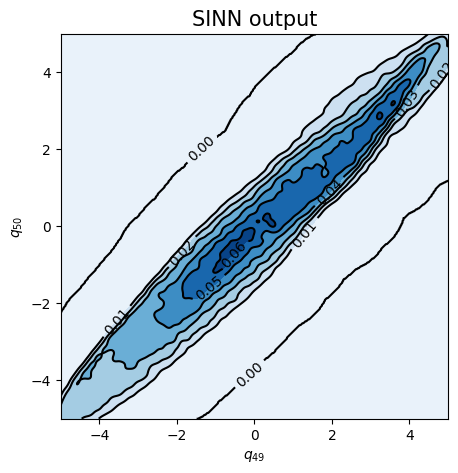

In [42]:
test7(model)

In [43]:
### Defining SINN model
net1 = SINN(2, 75, 4, 2).to(device) # input dimension, hidden size, number of layers, output dimension
model1 = Model(net=net1)
model1.train()

[0]-th step loss: 0.8319, 0.8482, acf: 0.09509, ccf: 0.13055, pdf: 0.29318, pdf2: 0.28991, acf2: 0.03945
[50]-th step loss: 0.1348, 0.1139, acf: 0.02512, ccf: 0.02521, pdf: 0.03639, pdf2: 0.01816, acf2: 0.00903
[100]-th step loss: 0.0389, 0.0403, acf: 0.00616, ccf: 0.00619, pdf: 0.01696, pdf2: 0.00884, acf2: 0.00218
[150]-th step loss: 0.3600, 0.3703, acf: 0.04779, ccf: 0.04769, pdf: 0.15499, pdf2: 0.10921, acf2: 0.01064
[200]-th step loss: 0.3408, 0.3168, acf: 0.02557, ccf: 0.02551, pdf: 0.15367, pdf2: 0.10908, acf2: 0.00302
[250]-th step loss: 0.3856, 0.4087, acf: 0.06417, ccf: 0.06402, pdf: 0.15305, pdf2: 0.10909, acf2: 0.01834
[300]-th step loss: 0.3029, 0.1613, acf: 0.00217, ccf: 0.00201, pdf: 0.10172, pdf2: 0.05306, acf2: 0.00236
[350]-th step loss: 0.0516, 0.0467, acf: 0.00057, ccf: 0.00024, pdf: 0.02601, pdf2: 0.01861, acf2: 0.00131
[400]-th step loss: 0.0611, 0.0655, acf: 0.01150, ccf: 0.01148, pdf: 0.02553, pdf2: 0.01505, acf2: 0.00199
[450]-th step loss: 0.0341, 0.0399, acf:

[3850]-th step loss: 0.0039, 0.0020, acf: 0.00015, ccf: 0.00014, pdf: 0.00026, pdf2: 0.00064, acf2: 0.00080
[3900]-th step loss: 0.0010, 0.0023, acf: 0.00063, ccf: 0.00062, pdf: 0.00017, pdf2: 0.00049, acf2: 0.00039
[3950]-th step loss: 0.0015, 0.0100, acf: 0.00281, ccf: 0.00278, pdf: 0.00126, pdf2: 0.00186, acf2: 0.00132
[4000]-th step loss: 0.0032, 0.0036, acf: 0.00038, ccf: 0.00036, pdf: 0.00073, pdf2: 0.00185, acf2: 0.00024
[4050]-th step loss: 0.0019, 0.0016, acf: 0.00015, ccf: 0.00015, pdf: 0.00044, pdf2: 0.00056, acf2: 0.00031
[4100]-th step loss: 0.0015, 0.0016, acf: 0.00040, ccf: 0.00039, pdf: 0.00020, pdf2: 0.00043, acf2: 0.00022
[4150]-th step loss: 0.0007, 0.0009, acf: 0.00005, ccf: 0.00005, pdf: 0.00015, pdf2: 0.00035, acf2: 0.00026
[4200]-th step loss: 0.0006, 0.0007, acf: 0.00006, ccf: 0.00005, pdf: 0.00009, pdf2: 0.00028, acf2: 0.00020
[4250]-th step loss: 0.0009, 0.0008, acf: 0.00006, ccf: 0.00006, pdf: 0.00009, pdf2: 0.00039, acf2: 0.00016
[4300]-th step loss: 0.0023,

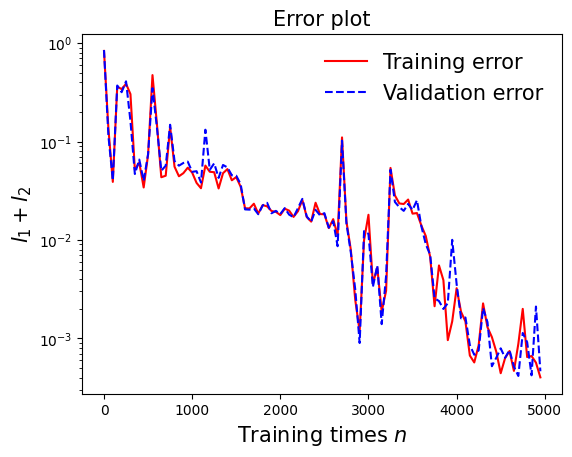

In [44]:
draw_loss(model1)

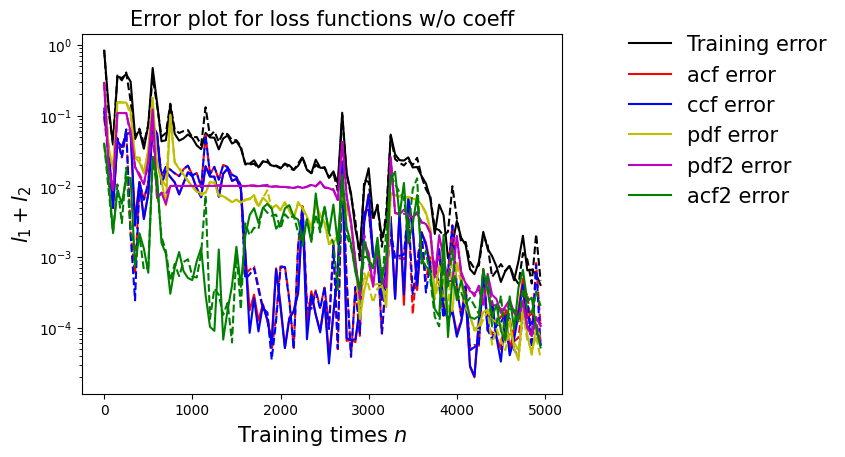

In [45]:
draw_errors(model1)

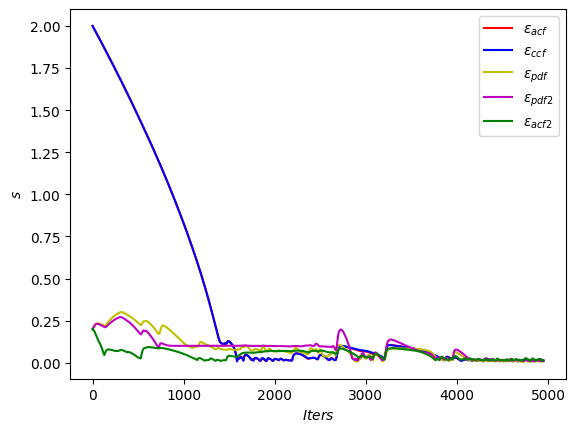

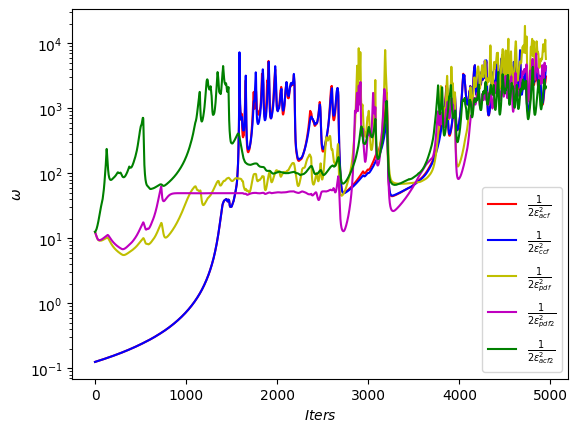

In [46]:
draw_adaptive_w(model1)
draw_epoch_w(model1)

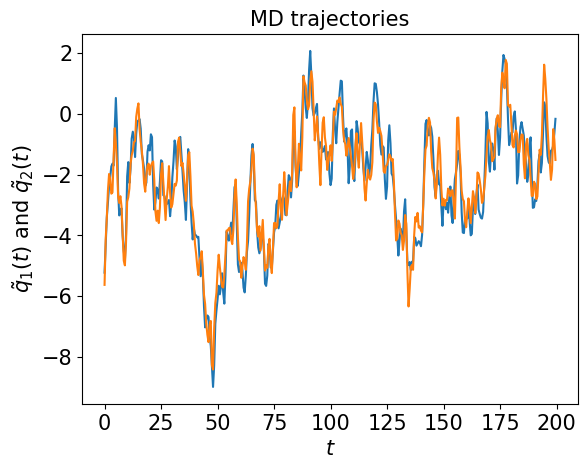

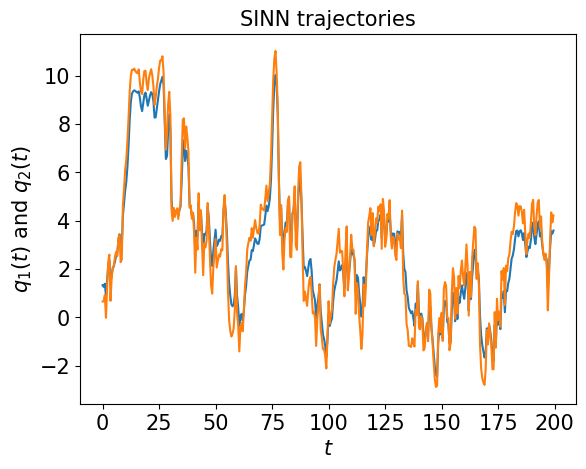

In [47]:
test1(model1)

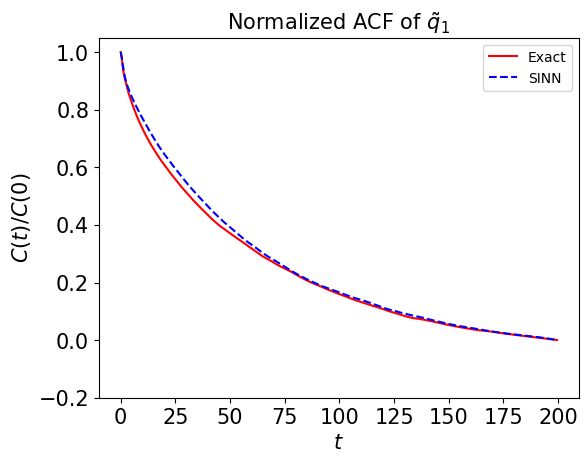

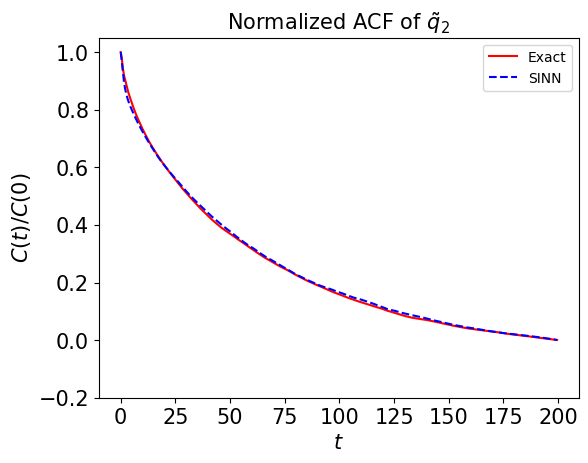

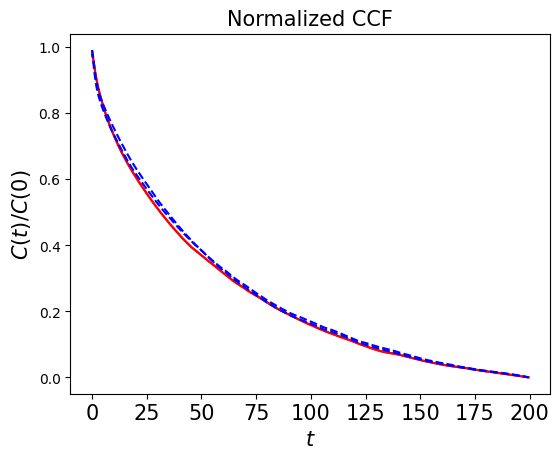

In [48]:
test2(model1)

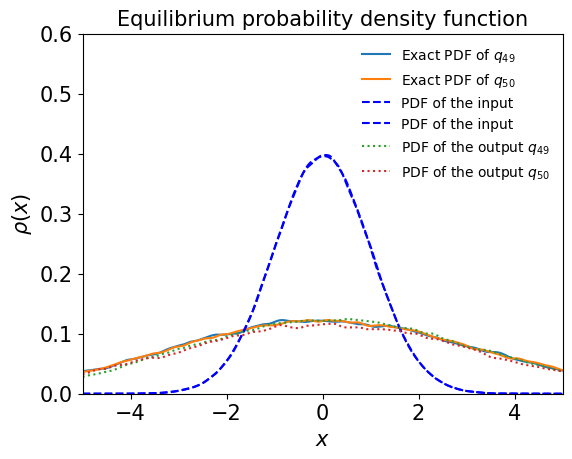

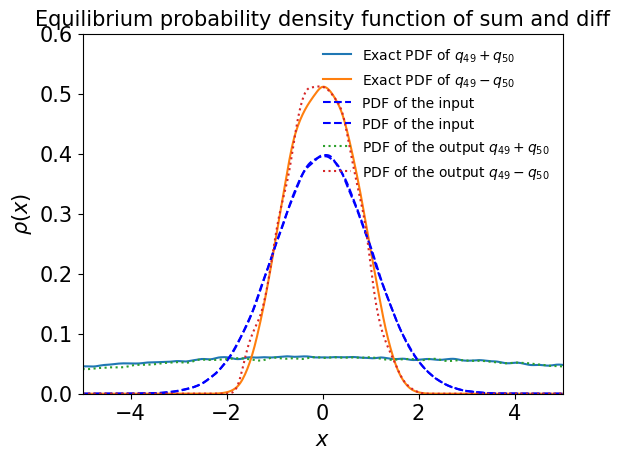

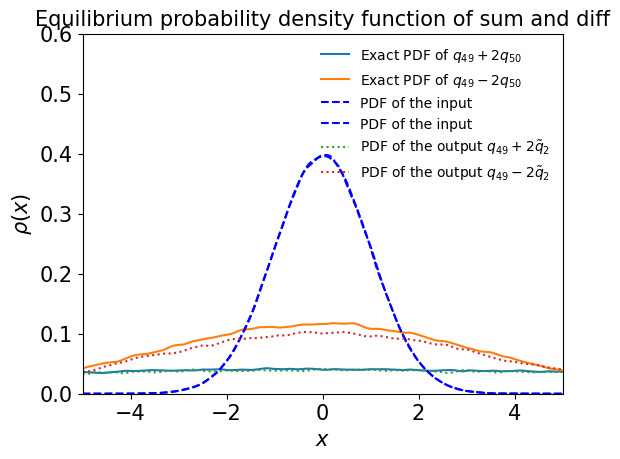

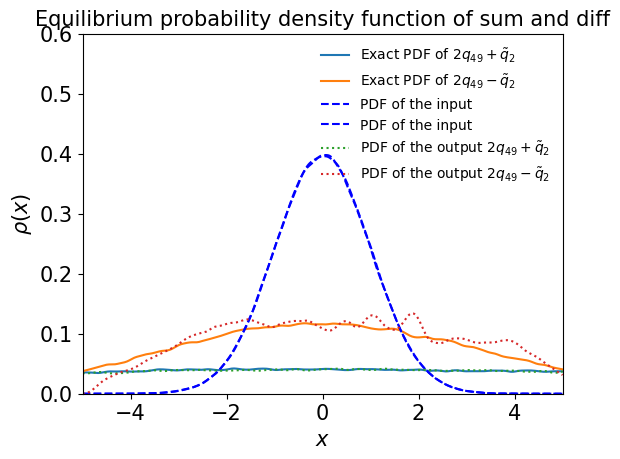

In [49]:
test3(model1)

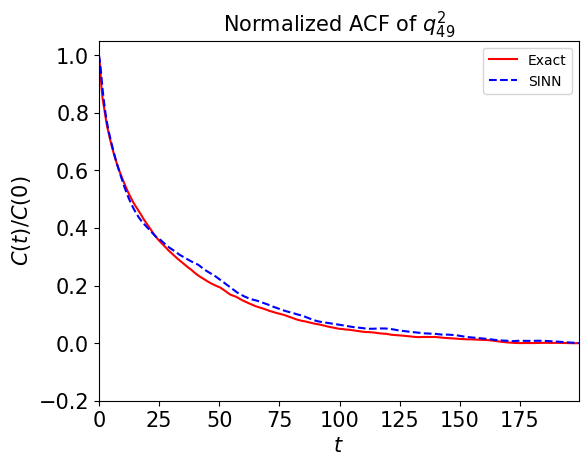

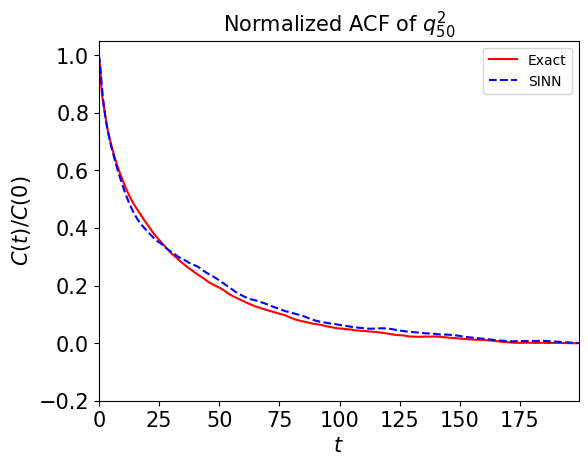

In [50]:
test4(model1)

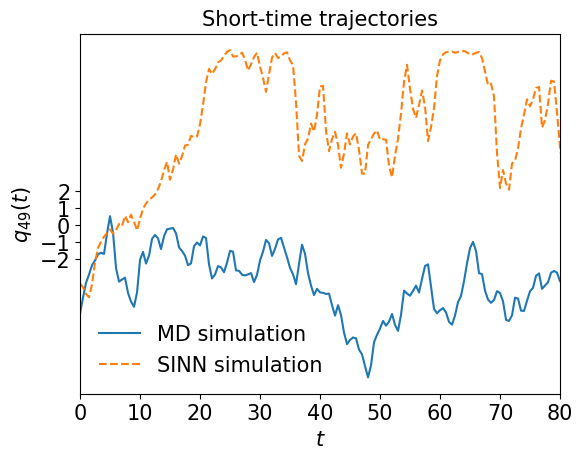

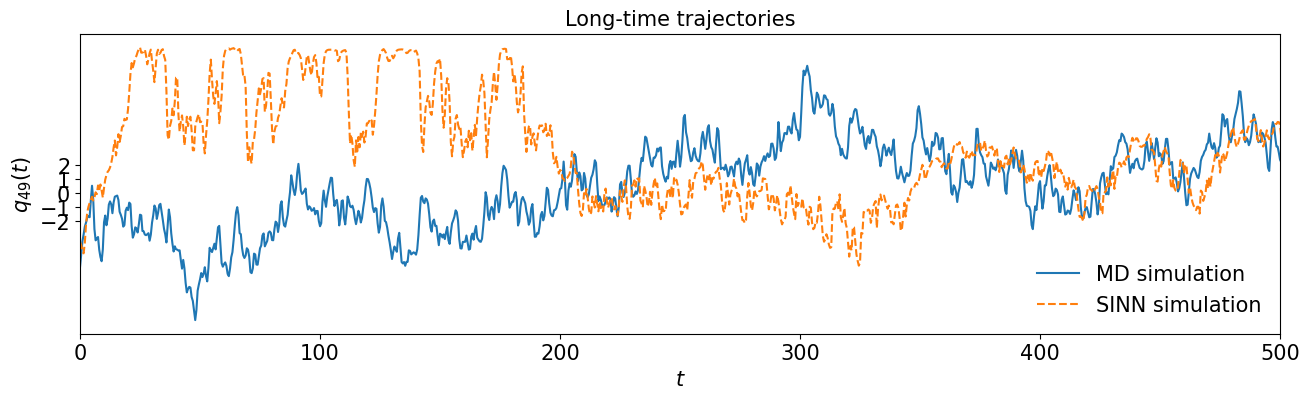

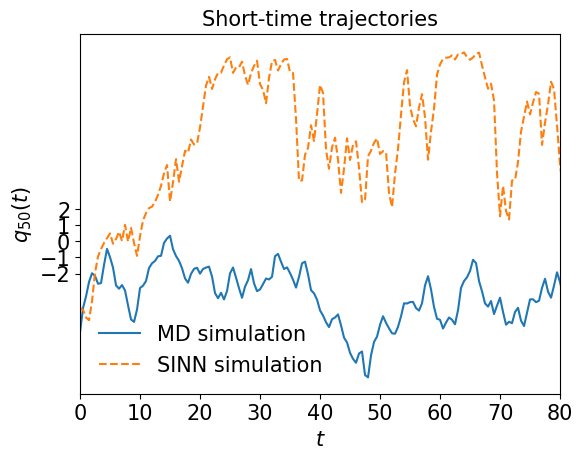

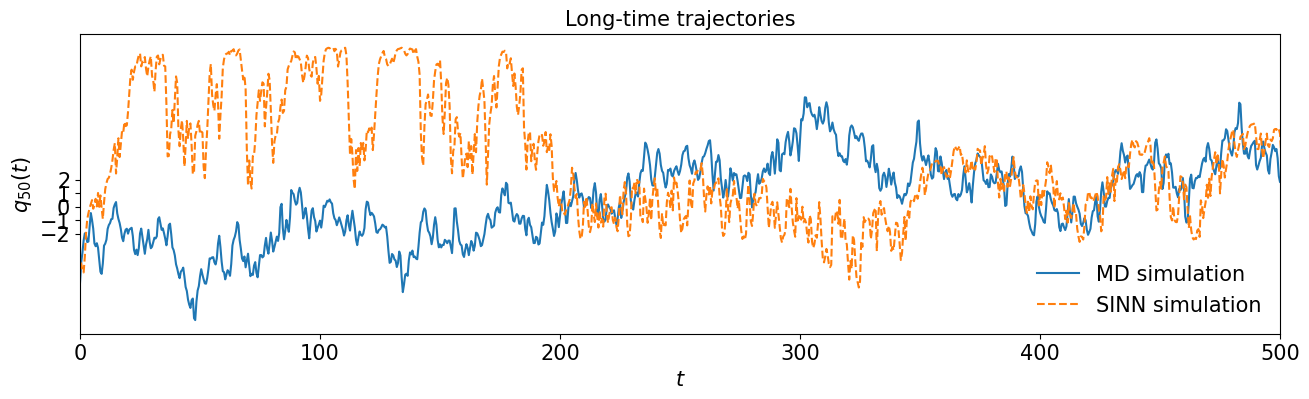

In [51]:
test5(model1)

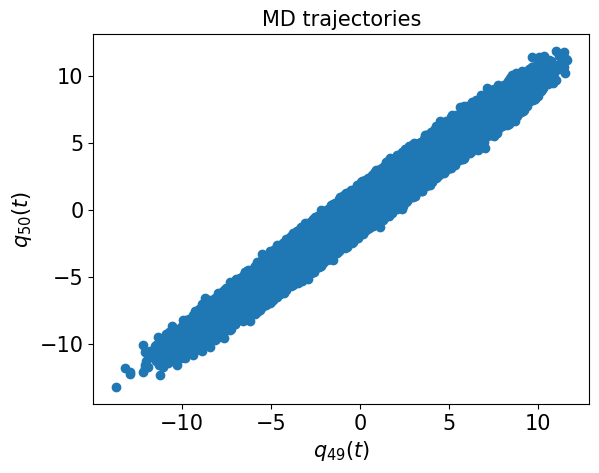

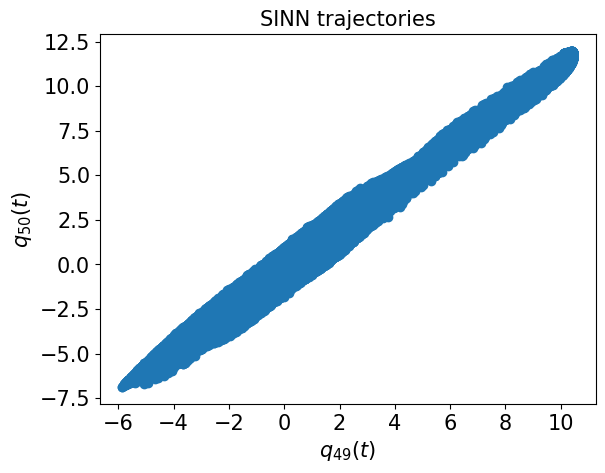

In [52]:
test6(model1)

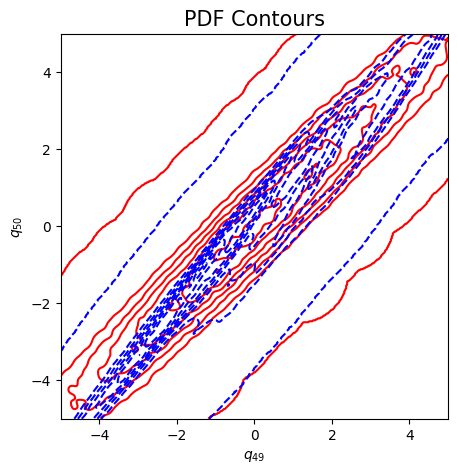

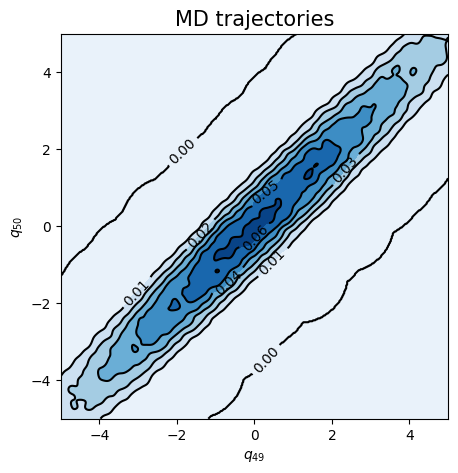

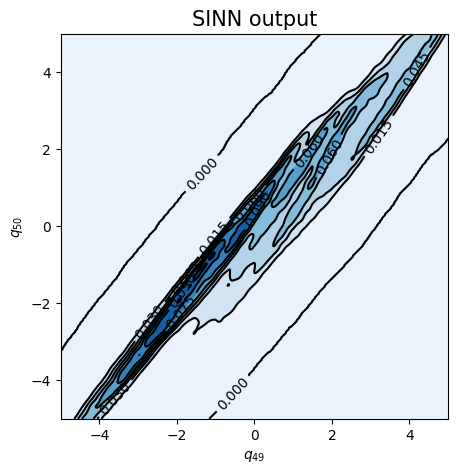

In [53]:
test7(model1)

In [54]:
### Defining SINN model
net2 = SINN(2, 75, 4, 2).to(device) # input dimension, hidden size, number of layers, output dimension
model2 = Model(net=net2)
model2.train()

[0]-th step loss: 0.8631, 0.8329, acf: 0.09614, ccf: 0.11323, pdf: 0.29312, pdf2: 0.29017, acf2: 0.04019
[50]-th step loss: 0.1824, 0.1721, acf: 0.05910, ccf: 0.05901, pdf: 0.02341, pdf2: 0.01241, acf2: 0.01822
[100]-th step loss: 0.5103, 0.5153, acf: 0.04795, ccf: 0.04784, pdf: 0.29957, pdf2: 0.10920, acf2: 0.01076
[150]-th step loss: 0.0879, 0.0784, acf: 0.01381, ccf: 0.01377, pdf: 0.01953, pdf2: 0.02944, acf2: 0.00186
[200]-th step loss: 0.0666, 0.0601, acf: 0.01966, ccf: 0.01959, pdf: 0.01007, pdf2: 0.01039, acf2: 0.00041
[250]-th step loss: 0.2618, 0.2395, acf: 0.07085, ccf: 0.07075, pdf: 0.04389, pdf2: 0.03090, acf2: 0.02312
[300]-th step loss: 0.0357, 0.0360, acf: 0.00904, ccf: 0.00901, pdf: 0.01054, pdf2: 0.00658, acf2: 0.00084
[350]-th step loss: 0.0294, 0.0238, acf: 0.00813, ccf: 0.00810, pdf: 0.00377, pdf2: 0.00304, acf2: 0.00072
[400]-th step loss: 0.0674, 0.0425, acf: 0.01895, ccf: 0.01893, pdf: 0.00241, pdf2: 0.00178, acf2: 0.00044
[450]-th step loss: 0.0638, 0.0493, acf:

[3850]-th step loss: 0.0314, 0.0324, acf: 0.00022, ccf: 0.00023, pdf: 0.00829, pdf2: 0.00551, acf2: 0.01815
[3900]-th step loss: 0.0378, 0.0318, acf: 0.00019, ccf: 0.00020, pdf: 0.00829, pdf2: 0.00669, acf2: 0.01648
[3950]-th step loss: 0.0272, 0.0323, acf: 0.00028, ccf: 0.00029, pdf: 0.00829, pdf2: 0.00509, acf2: 0.01837
[4000]-th step loss: 0.0302, 0.0324, acf: 0.00031, ccf: 0.00029, pdf: 0.00829, pdf2: 0.00677, acf2: 0.01677
[4050]-th step loss: 0.0307, 0.0386, acf: 0.00067, ccf: 0.00068, pdf: 0.00829, pdf2: 0.00755, acf2: 0.02136
[4100]-th step loss: 0.0331, 0.0261, acf: 0.00172, ccf: 0.00162, pdf: 0.00829, pdf2: 0.00824, acf2: 0.00625
[4150]-th step loss: 0.0335, 0.0399, acf: 0.00073, ccf: 0.00075, pdf: 0.00829, pdf2: 0.00888, acf2: 0.02129
[4200]-th step loss: 0.0307, 0.0322, acf: 0.00016, ccf: 0.00017, pdf: 0.00829, pdf2: 0.00656, acf2: 0.01706
[4250]-th step loss: 0.0304, 0.0306, acf: 0.00009, ccf: 0.00006, pdf: 0.00829, pdf2: 0.00592, acf2: 0.01624
[4300]-th step loss: 0.0279,

[7650]-th step loss: 0.0112, 0.0137, acf: 0.00038, ccf: 0.00038, pdf: 0.00339, pdf2: 0.00417, acf2: 0.00537
[7700]-th step loss: 0.0095, 0.0111, acf: 0.00026, ccf: 0.00027, pdf: 0.00201, pdf2: 0.00460, acf2: 0.00399
[7750]-th step loss: 0.0087, 0.0092, acf: 0.00009, ccf: 0.00009, pdf: 0.00210, pdf2: 0.00445, acf2: 0.00249
[7800]-th step loss: 0.0083, 0.0089, acf: 0.00010, ccf: 0.00009, pdf: 0.00266, pdf2: 0.00378, acf2: 0.00225
[7850]-th step loss: 0.0095, 0.0099, acf: 0.00032, ccf: 0.00027, pdf: 0.00341, pdf2: 0.00400, acf2: 0.00194
[7900]-th step loss: 0.0011, 0.0023, acf: 0.00043, ccf: 0.00044, pdf: 0.00042, pdf2: 0.00058, acf2: 0.00047
[7950]-th step loss: 0.0018, 0.0016, acf: 0.00025, ccf: 0.00024, pdf: 0.00037, pdf2: 0.00054, acf2: 0.00024
[8000]-th step loss: 0.0013, 0.0004, acf: 0.00007, ccf: 0.00005, pdf: 0.00011, pdf2: 0.00011, acf2: 0.00008
[8050]-th step loss: 0.0019, 0.0010, acf: 0.00015, ccf: 0.00015, pdf: 0.00035, pdf2: 0.00018, acf2: 0.00015
[8100]-th step loss: 0.0016,

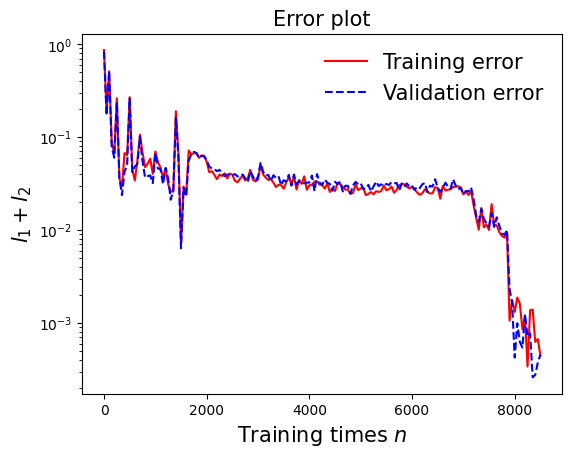

In [55]:
draw_loss(model2)

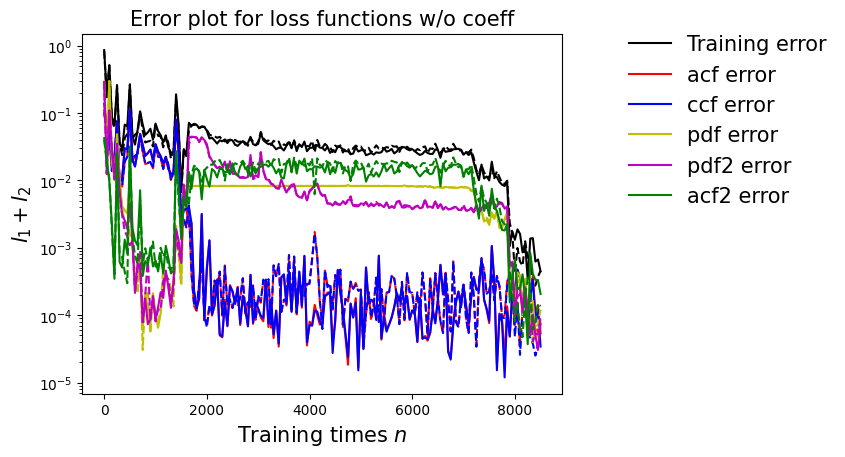

In [56]:
draw_errors(model2)

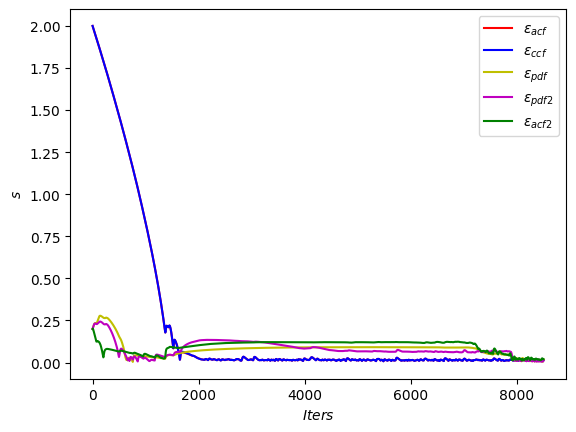

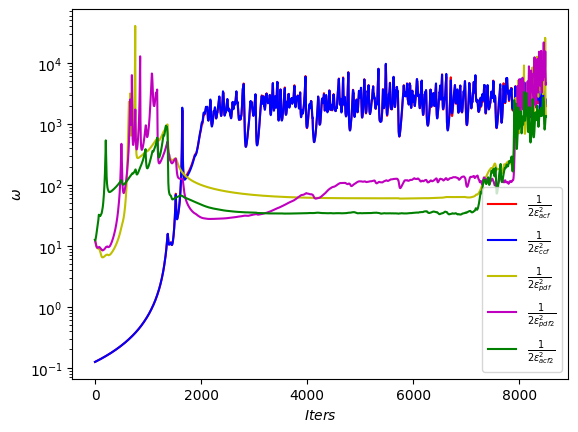

In [57]:
draw_adaptive_w(model2)
draw_epoch_w(model2)

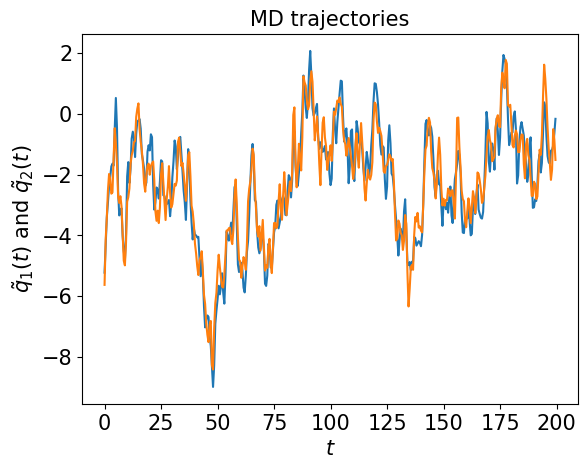

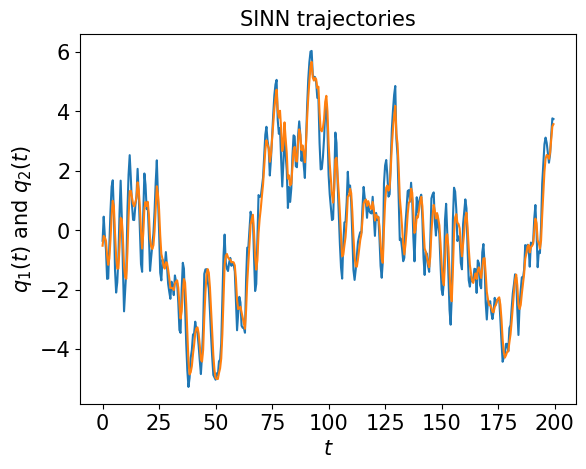

In [58]:
test1(model2)

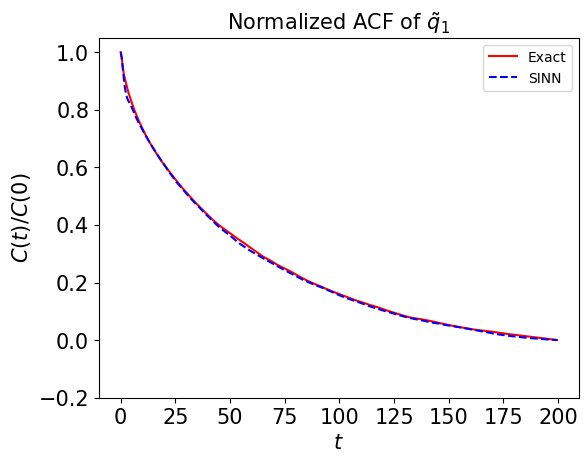

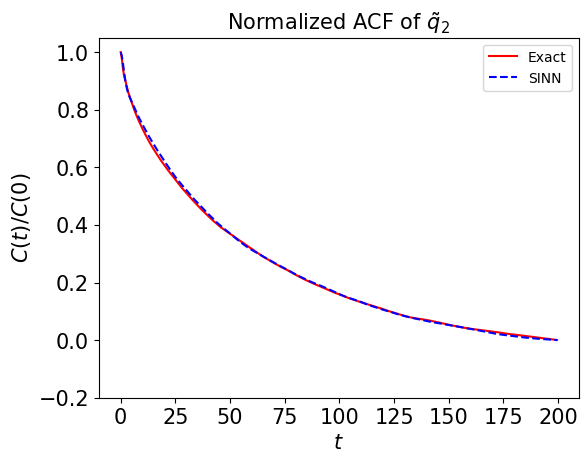

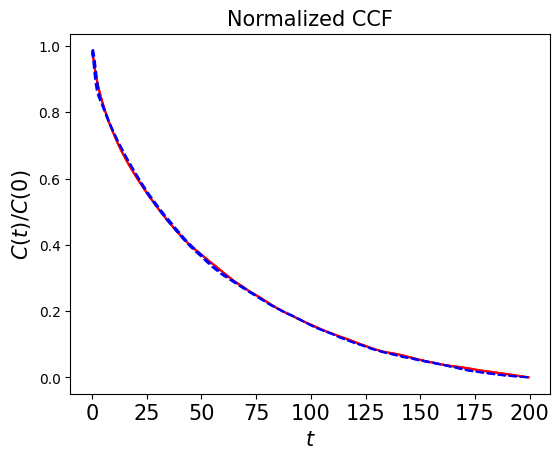

In [59]:
test2(model2)

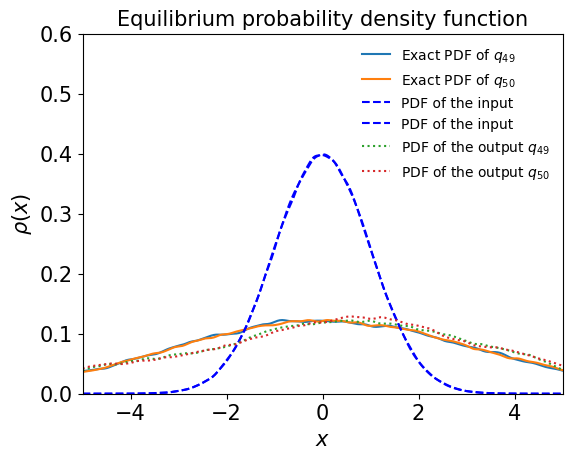

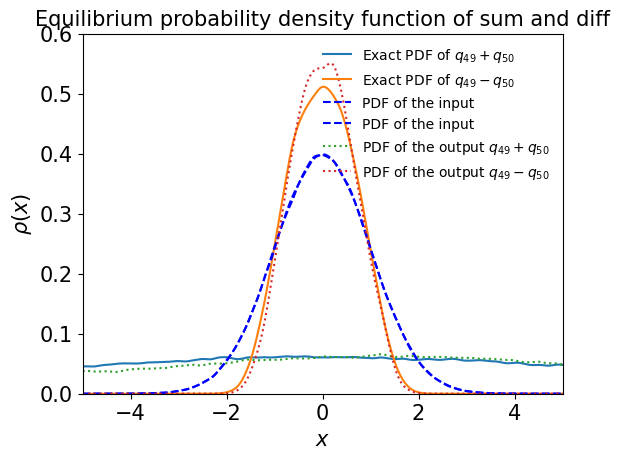

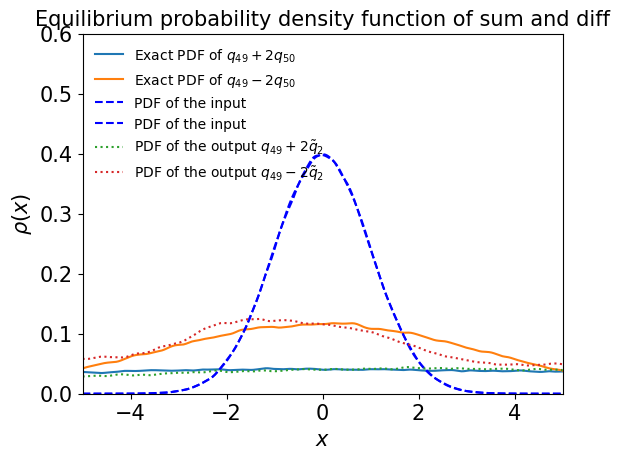

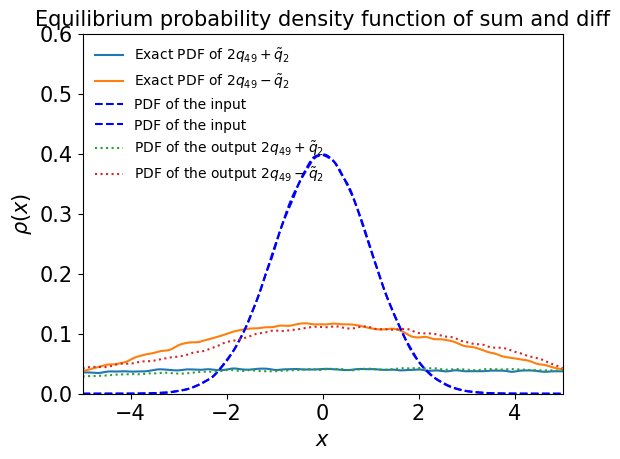

In [60]:
test3(model2)

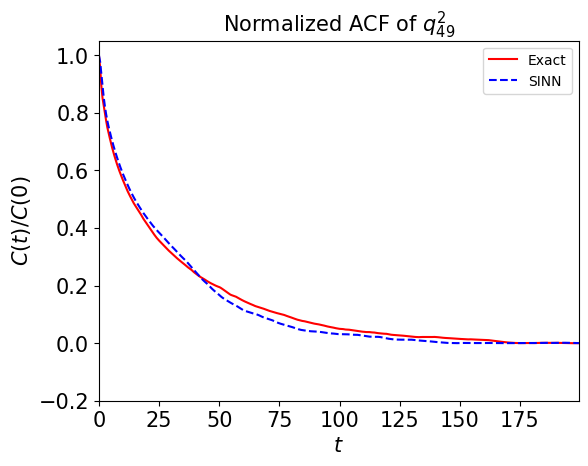

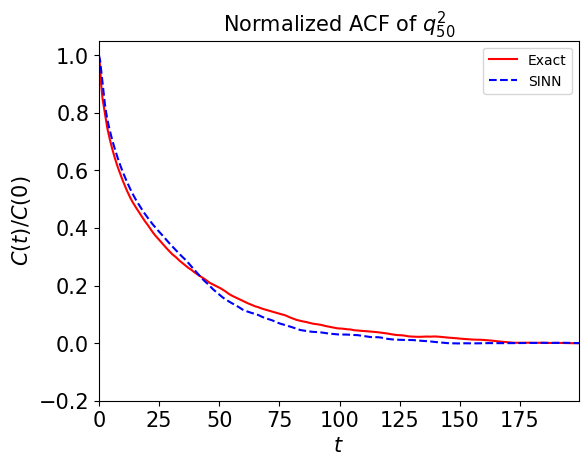

In [61]:
test4(model2)

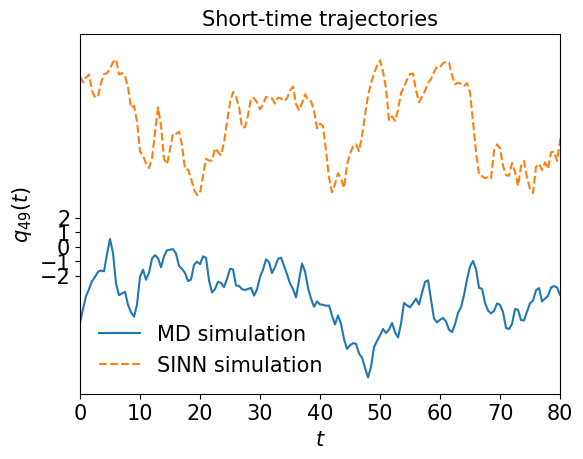

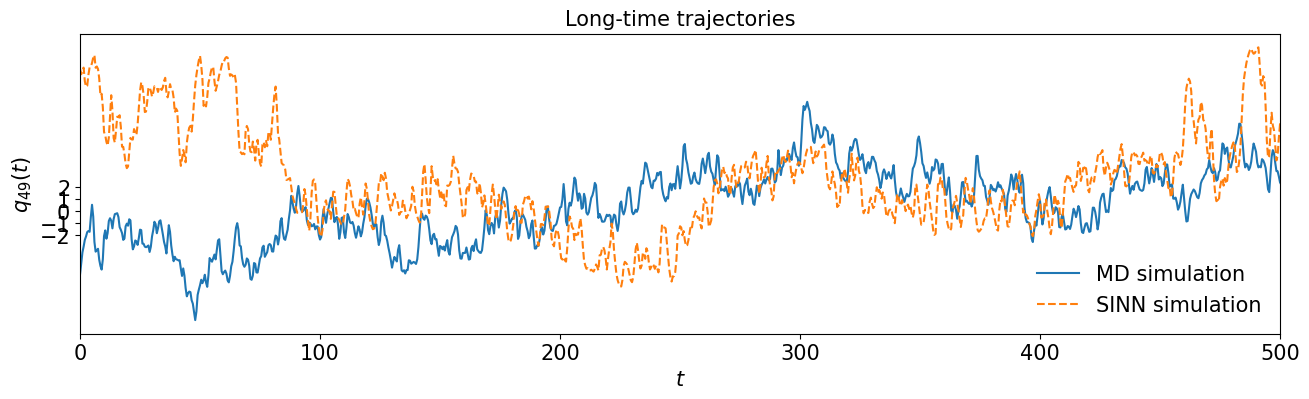

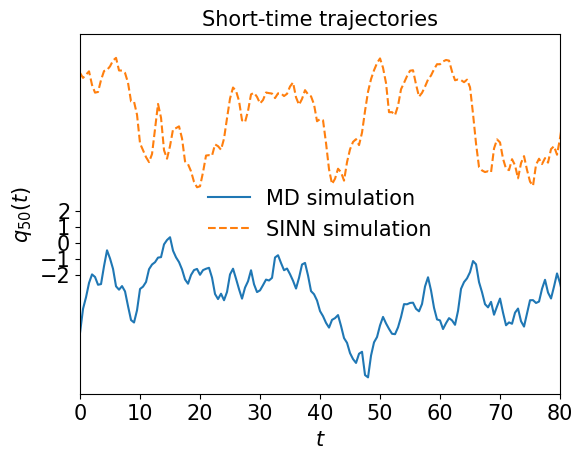

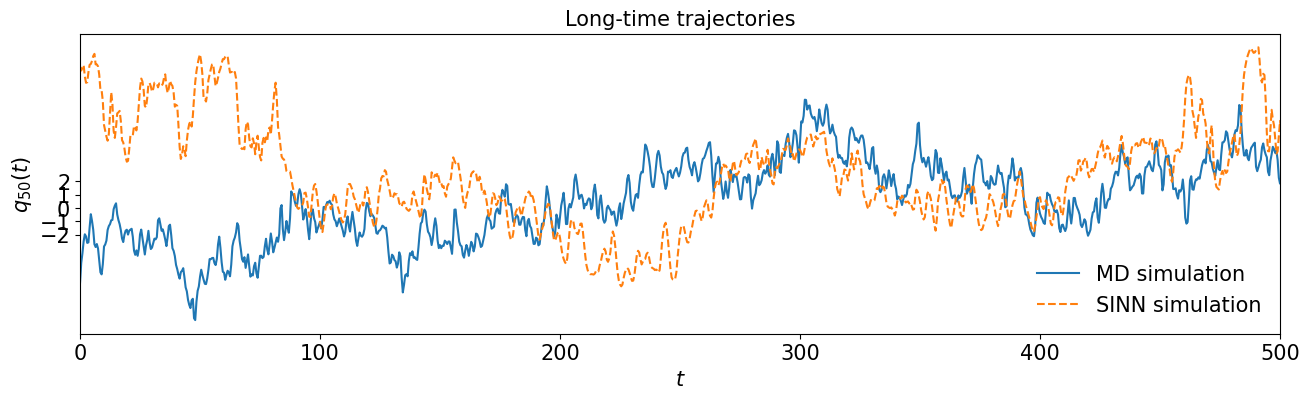

In [62]:
test5(model2)

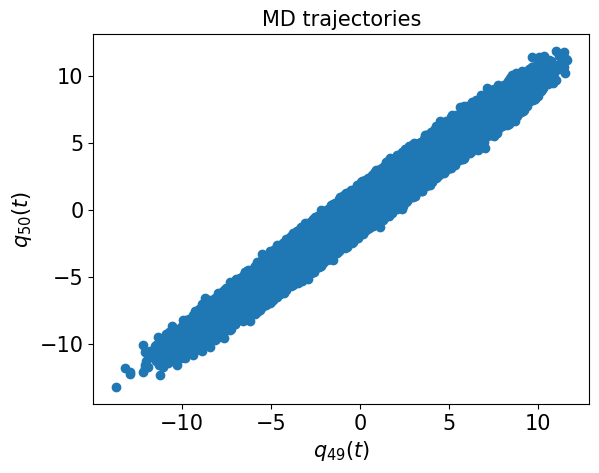

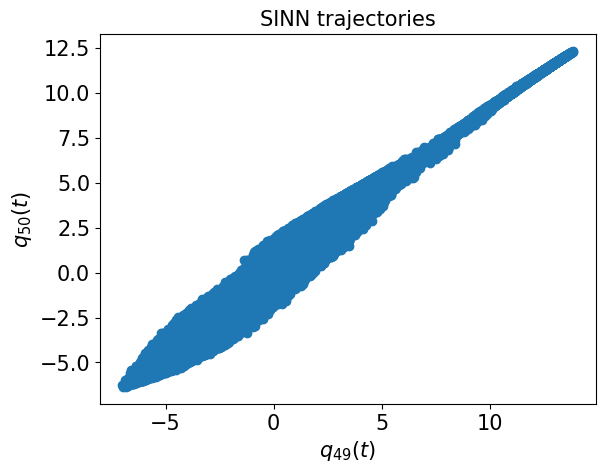

In [63]:
test6(model2)

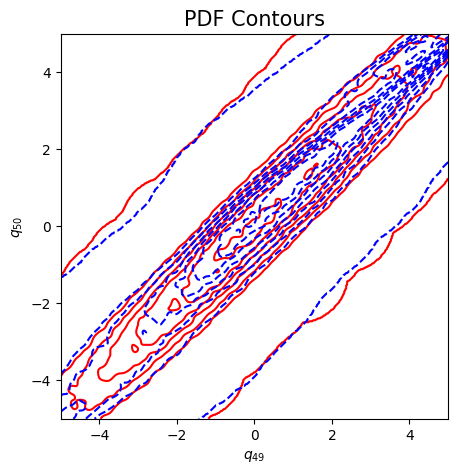

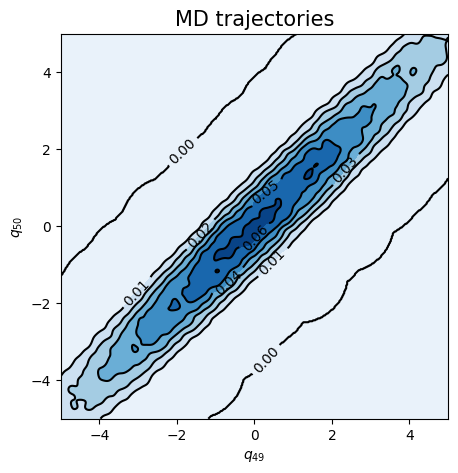

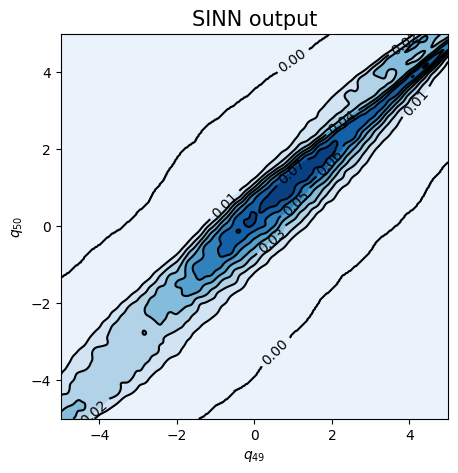

In [64]:
test7(model2)

In [65]:
### Defining SINN model
net3 = SINN(2, 75, 4, 2).to(device) # input dimension, hidden size, number of layers, output dimension
model3 = Model(net=net3)
model3.train()

[0]-th step loss: 0.8179, 0.8122, acf: 0.09397, ccf: 0.09675, pdf: 0.29318, pdf2: 0.28990, acf2: 0.03837
[50]-th step loss: 0.1222, 0.1336, acf: 0.04858, ccf: 0.04849, pdf: 0.01105, pdf2: 0.01089, acf2: 0.01461
[100]-th step loss: 0.0418, 0.0358, acf: 0.01378, ccf: 0.01376, pdf: 0.00356, pdf2: 0.00305, acf2: 0.00163
[150]-th step loss: 0.0247, 0.0255, acf: 0.00587, ccf: 0.00586, pdf: 0.00638, pdf2: 0.00694, acf2: 0.00045
[200]-th step loss: 0.0828, 0.0752, acf: 0.03326, ccf: 0.03319, pdf: 0.00132, pdf2: 0.00255, acf2: 0.00486
[250]-th step loss: 0.0622, 0.0600, acf: 0.02749, ccf: 0.02741, pdf: 0.00107, pdf2: 0.00212, acf2: 0.00188
[300]-th step loss: 0.3829, 0.4109, acf: 0.03658, ccf: 0.31200, pdf: 0.00829, pdf2: 0.04588, acf2: 0.00817
[350]-th step loss: 0.4025, 0.3992, acf: 0.02529, ccf: 0.31807, pdf: 0.00829, pdf2: 0.04477, acf2: 0.00276
[400]-th step loss: 0.3805, 0.3760, acf: 0.02130, ccf: 0.30093, pdf: 0.00829, pdf2: 0.04473, acf2: 0.00070
[450]-th step loss: 0.3928, 0.3850, acf:

[3850]-th step loss: 0.3962, 0.3816, acf: 0.01881, ccf: 0.30947, pdf: 0.00829, pdf2: 0.04473, acf2: 0.00027
[3900]-th step loss: 0.3929, 0.3834, acf: 0.01798, ccf: 0.31218, pdf: 0.00829, pdf2: 0.04473, acf2: 0.00019
[3950]-th step loss: 0.4002, 0.3812, acf: 0.01759, ccf: 0.31042, pdf: 0.00829, pdf2: 0.04474, acf2: 0.00017
[4000]-th step loss: 0.3794, 0.3749, acf: 0.01994, ccf: 0.30148, pdf: 0.00829, pdf2: 0.04474, acf2: 0.00045
[4050]-th step loss: 0.3991, 0.3882, acf: 0.01552, ccf: 0.31957, pdf: 0.00829, pdf2: 0.04473, acf2: 0.00006
[4100]-th step loss: 0.3965, 0.3859, acf: 0.01728, ccf: 0.31549, pdf: 0.00829, pdf2: 0.04473, acf2: 0.00014
[4150]-th step loss: 0.3902, 0.3827, acf: 0.01818, ccf: 0.31129, pdf: 0.00829, pdf2: 0.04473, acf2: 0.00021
[4200]-th step loss: 0.3833, 0.3838, acf: 0.01734, ccf: 0.31335, pdf: 0.00829, pdf2: 0.04473, acf2: 0.00013
[4250]-th step loss: 0.3824, 0.3789, acf: 0.01876, ccf: 0.30680, pdf: 0.00829, pdf2: 0.04473, acf2: 0.00027
[4300]-th step loss: 0.3996,

[7650]-th step loss: 0.3857, 0.3908, acf: 0.01550, ccf: 0.32223, pdf: 0.00829, pdf2: 0.04469, acf2: 0.00007
[7700]-th step loss: 0.3938, 0.3872, acf: 0.01742, ccf: 0.31665, pdf: 0.00829, pdf2: 0.04469, acf2: 0.00017
[7750]-th step loss: 0.3895, 0.3770, acf: 0.01920, ccf: 0.30450, pdf: 0.00829, pdf2: 0.04470, acf2: 0.00032
[7800]-th step loss: 0.3794, 0.3863, acf: 0.01669, ccf: 0.31656, pdf: 0.00829, pdf2: 0.04469, acf2: 0.00009
[7850]-th step loss: 0.3917, 0.3895, acf: 0.01577, ccf: 0.32073, pdf: 0.00829, pdf2: 0.04469, acf2: 0.00006
[7900]-th step loss: 0.3895, 0.3836, acf: 0.01740, ccf: 0.31307, pdf: 0.00829, pdf2: 0.04468, acf2: 0.00013
[7950]-th step loss: 0.3831, 0.3817, acf: 0.01740, ccf: 0.31115, pdf: 0.00829, pdf2: 0.04468, acf2: 0.00014
[8000]-th step loss: 0.4026, 0.3855, acf: 0.01791, ccf: 0.31443, pdf: 0.00829, pdf2: 0.04467, acf2: 0.00019
[8050]-th step loss: 0.3900, 0.3833, acf: 0.01677, ccf: 0.31346, pdf: 0.00829, pdf2: 0.04469, acf2: 0.00012
[8100]-th step loss: 0.3860,

[11450]-th step loss: 0.3903, 0.3834, acf: 0.01765, ccf: 0.31306, pdf: 0.00829, pdf2: 0.04428, acf2: 0.00014
[11500]-th step loss: 0.3865, 0.3851, acf: 0.01685, ccf: 0.31587, pdf: 0.00829, pdf2: 0.04400, acf2: 0.00009
[11550]-th step loss: 0.3903, 0.3856, acf: 0.01647, ccf: 0.31685, pdf: 0.00829, pdf2: 0.04394, acf2: 0.00007
[11600]-th step loss: 0.3898, 0.3847, acf: 0.01680, ccf: 0.31549, pdf: 0.00829, pdf2: 0.04397, acf2: 0.00010
[11650]-th step loss: 0.3871, 0.3845, acf: 0.01670, ccf: 0.31547, pdf: 0.00829, pdf2: 0.04395, acf2: 0.00008
[11700]-th step loss: 0.3858, 0.3830, acf: 0.01743, ccf: 0.31319, pdf: 0.00829, pdf2: 0.04393, acf2: 0.00012
[11750]-th step loss: 0.3990, 0.3882, acf: 0.01581, ccf: 0.32034, pdf: 0.00829, pdf2: 0.04366, acf2: 0.00005
[11800]-th step loss: 0.3873, 0.3850, acf: 0.01680, ccf: 0.31628, pdf: 0.00829, pdf2: 0.04353, acf2: 0.00010
[11850]-th step loss: 0.3854, 0.3767, acf: 0.01978, ccf: 0.30527, pdf: 0.00829, pdf2: 0.04299, acf2: 0.00037
[11900]-th step los

[15250]-th step loss: 0.3448, 0.3437, acf: 0.01668, ccf: 0.31502, pdf: 0.00829, pdf2: 0.00366, acf2: 0.00008
[15300]-th step loss: 0.3490, 0.3419, acf: 0.01719, ccf: 0.31245, pdf: 0.00829, pdf2: 0.00381, acf2: 0.00012
[15350]-th step loss: 0.3515, 0.3367, acf: 0.01935, ccf: 0.30501, pdf: 0.00829, pdf2: 0.00368, acf2: 0.00033
[15400]-th step loss: 0.3586, 0.3492, acf: 0.01485, ccf: 0.32235, pdf: 0.00829, pdf2: 0.00368, acf2: 0.00005
[15450]-th step loss: 0.3469, 0.3443, acf: 0.01647, ccf: 0.31583, pdf: 0.00829, pdf2: 0.00364, acf2: 0.00007
[15500]-th step loss: 0.3398, 0.3481, acf: 0.01610, ccf: 0.32003, pdf: 0.00829, pdf2: 0.00362, acf2: 0.00008
[15550]-th step loss: 0.3416, 0.3356, acf: 0.01975, ccf: 0.30353, pdf: 0.00829, pdf2: 0.00366, acf2: 0.00037
[15600]-th step loss: 0.3496, 0.3450, acf: 0.01626, ccf: 0.31644, pdf: 0.00829, pdf2: 0.00391, acf2: 0.00007
[15650]-th step loss: 0.3570, 0.3477, acf: 0.01588, ccf: 0.31981, pdf: 0.00829, pdf2: 0.00363, acf2: 0.00006
[15700]-th step los

[19050]-th step loss: 0.3474, 0.3508, acf: 0.01548, ccf: 0.32325, pdf: 0.00829, pdf2: 0.00370, acf2: 0.00008
[19100]-th step loss: 0.3532, 0.3388, acf: 0.01940, ccf: 0.30713, pdf: 0.00829, pdf2: 0.00363, acf2: 0.00033
[19150]-th step loss: 0.3547, 0.3488, acf: 0.01579, ccf: 0.32098, pdf: 0.00829, pdf2: 0.00363, acf2: 0.00008
[19200]-th step loss: 0.3532, 0.3508, acf: 0.01609, ccf: 0.32140, pdf: 0.00829, pdf2: 0.00493, acf2: 0.00010
[19250]-th step loss: 0.3472, 0.3451, acf: 0.01627, ccf: 0.31676, pdf: 0.00829, pdf2: 0.00370, acf2: 0.00008
[19300]-th step loss: 0.3515, 0.3451, acf: 0.01658, ccf: 0.31641, pdf: 0.00829, pdf2: 0.00375, acf2: 0.00009
[19350]-th step loss: 0.3573, 0.3499, acf: 0.01591, ccf: 0.32195, pdf: 0.00829, pdf2: 0.00363, acf2: 0.00009
[19400]-th step loss: 0.3608, 0.3536, acf: 0.01428, ccf: 0.32709, pdf: 0.00829, pdf2: 0.00390, acf2: 0.00008
[19450]-th step loss: 0.3464, 0.3429, acf: 0.01755, ccf: 0.31330, pdf: 0.00829, pdf2: 0.00363, acf2: 0.00014
[19500]-th step los

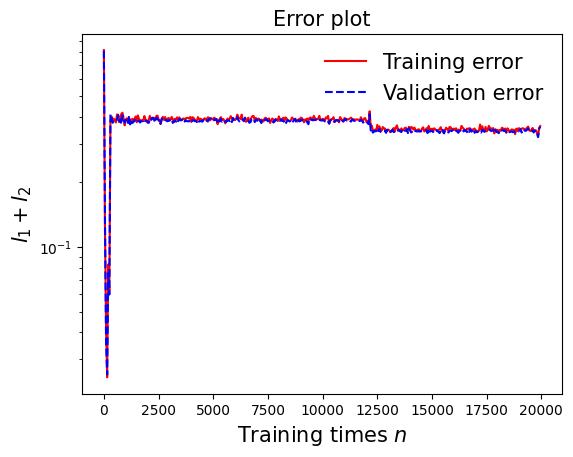

In [66]:
draw_loss(model3)

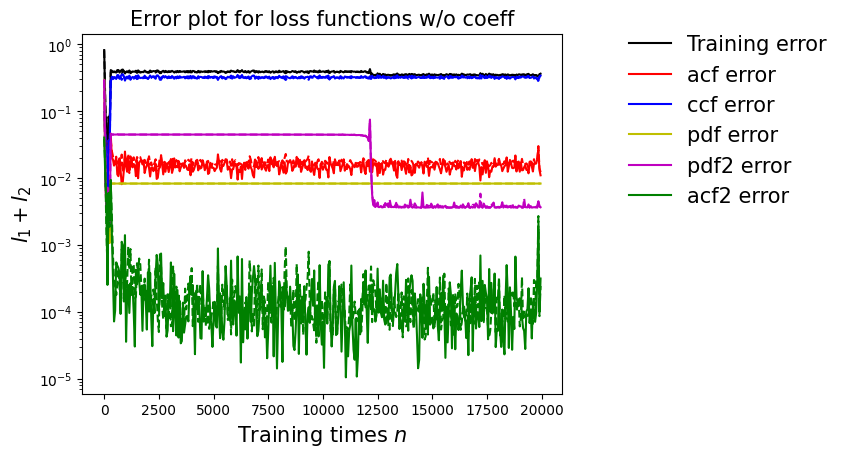

In [67]:
draw_errors(model3)

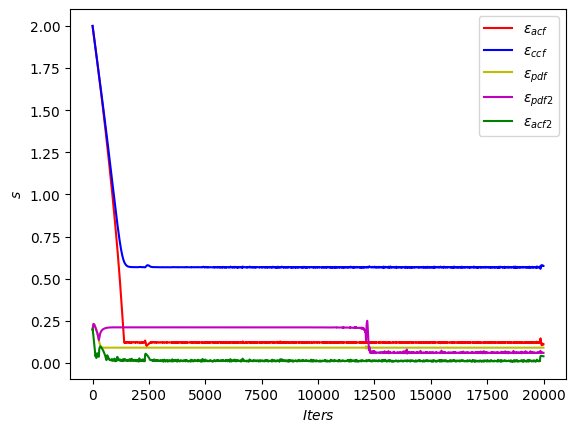

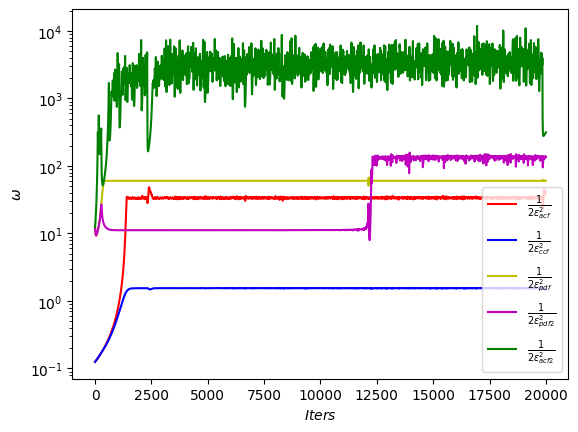

In [68]:
draw_adaptive_w(model3)
draw_epoch_w(model3)

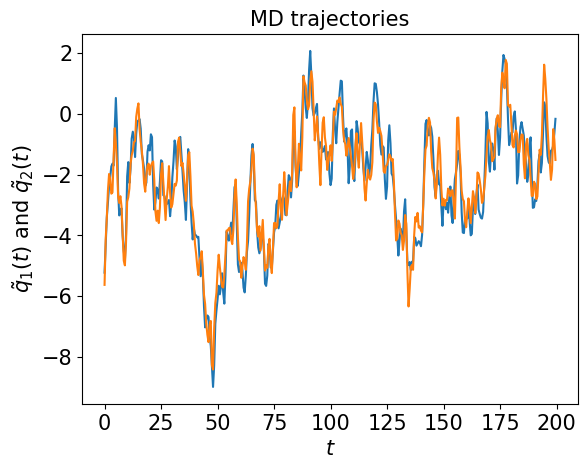

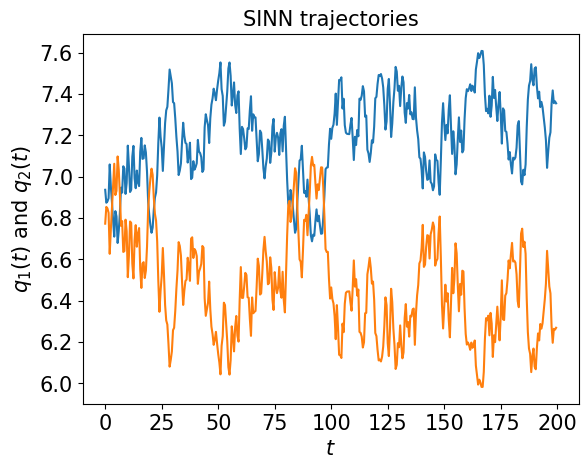

In [69]:
test1(model3)

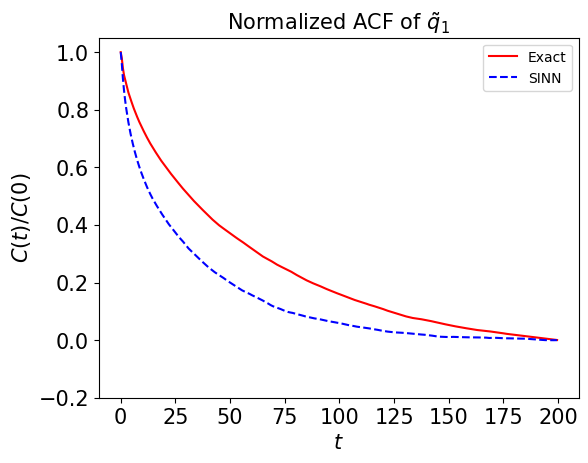

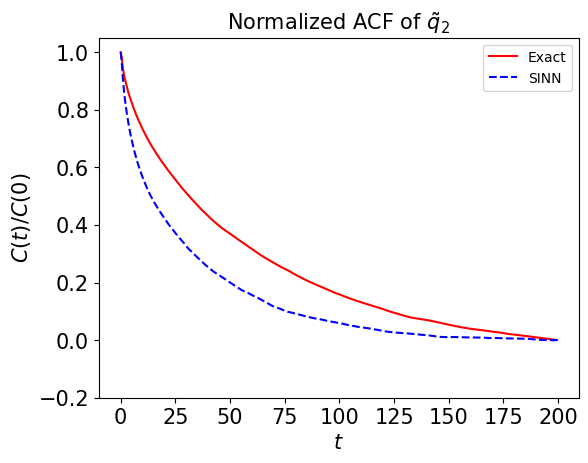

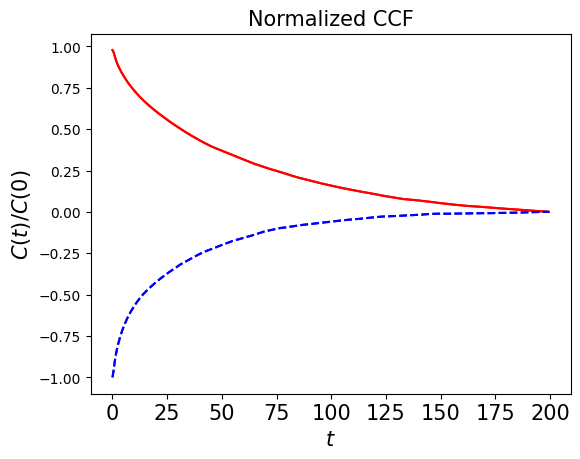

In [70]:
test2(model3)

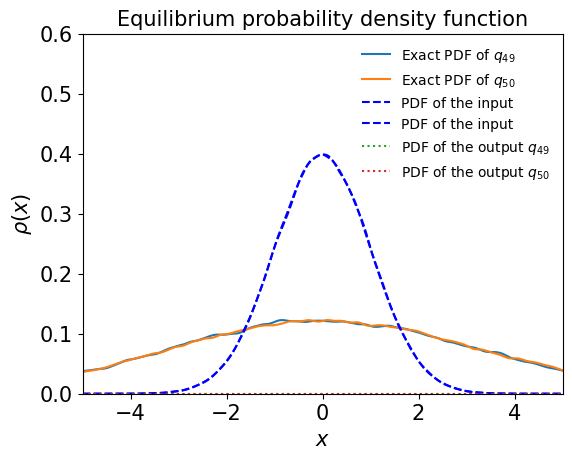

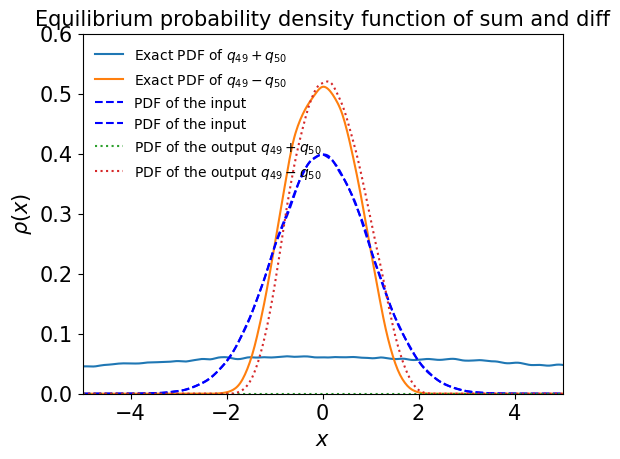

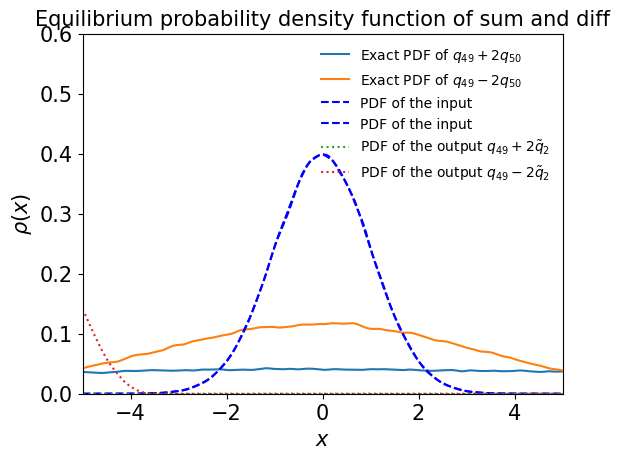

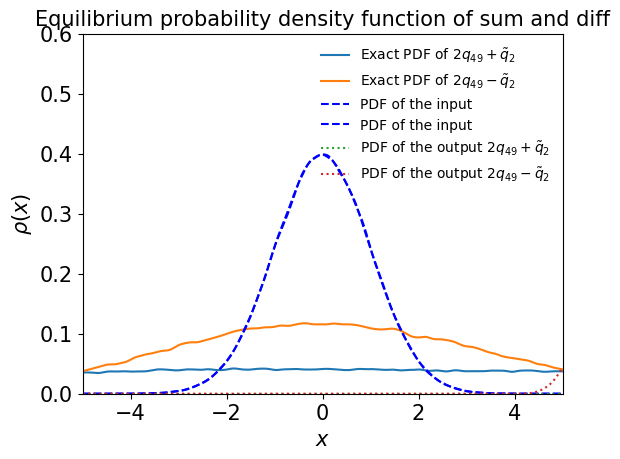

In [71]:
test3(model3)

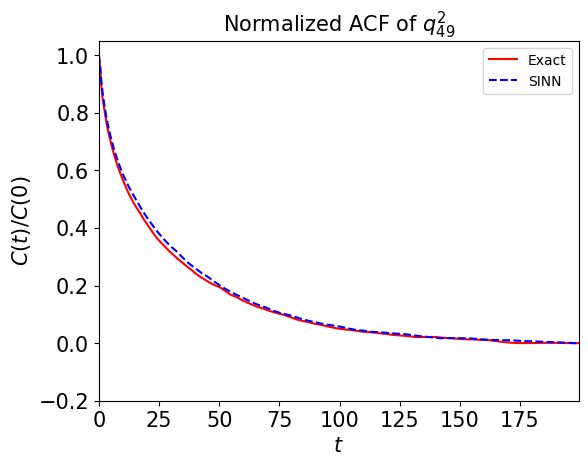

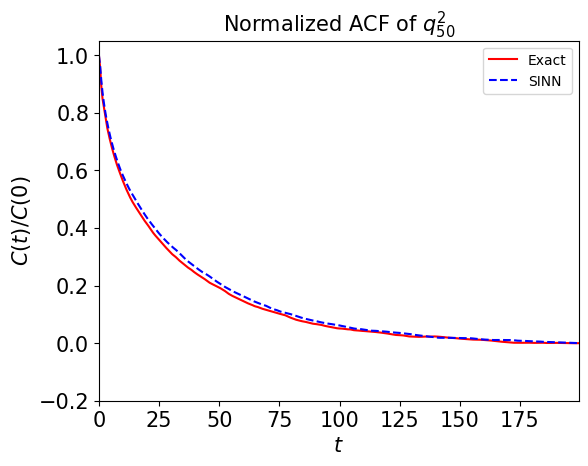

In [72]:
test4(model3)

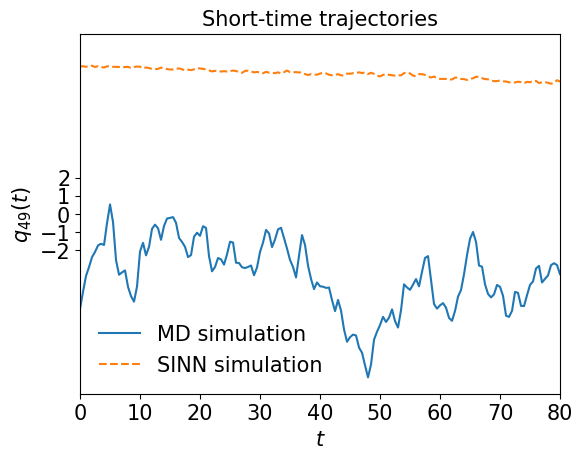

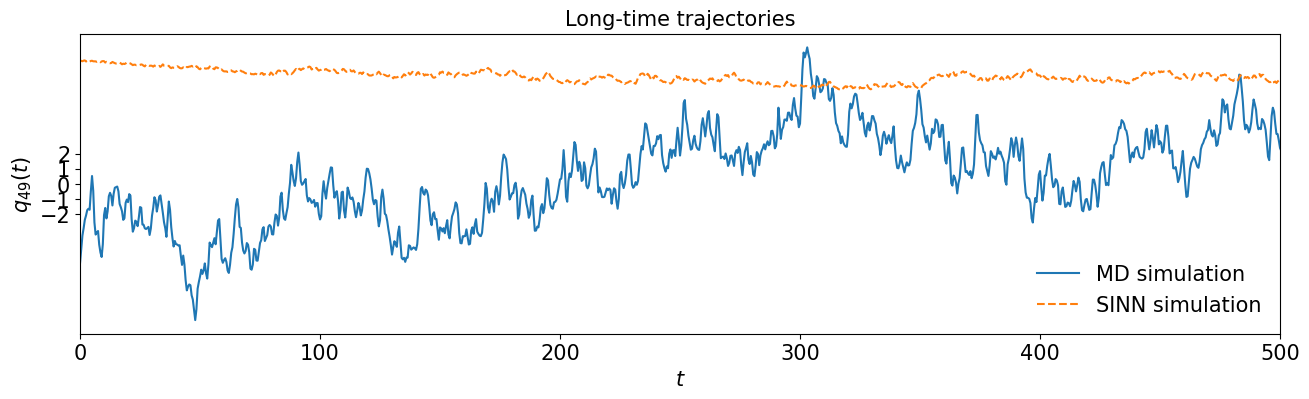

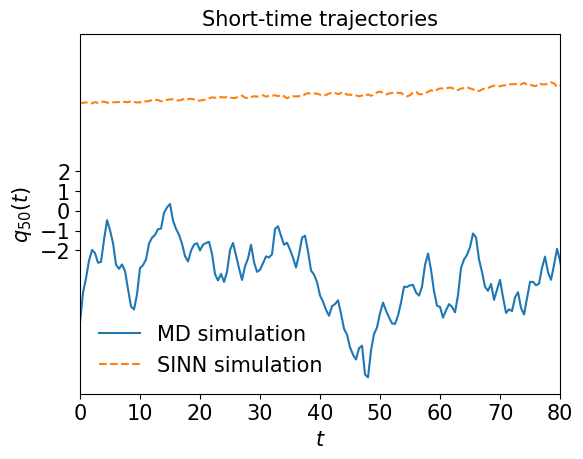

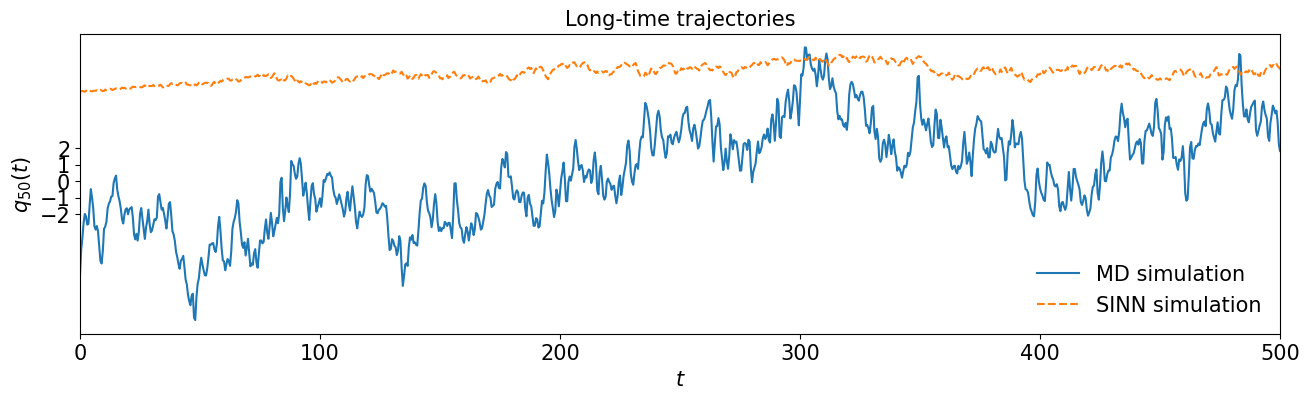

In [73]:
test5(model3)

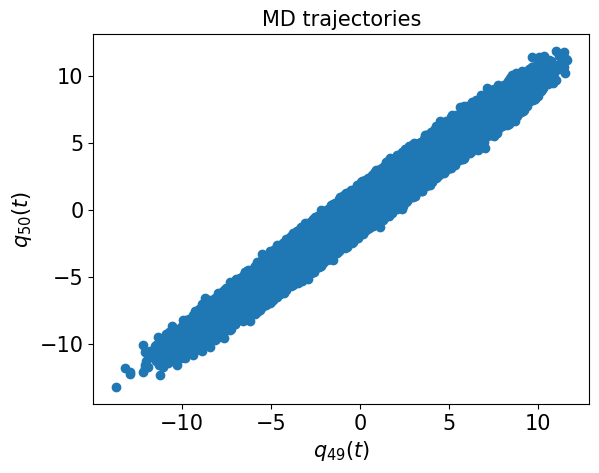

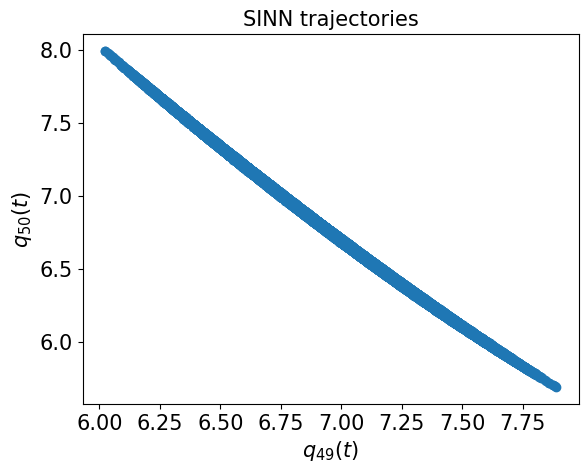

In [74]:
test6(model3)

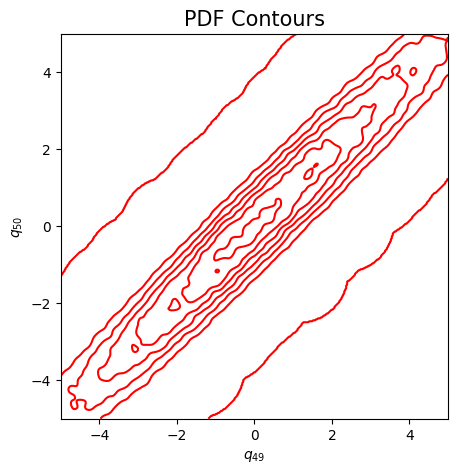

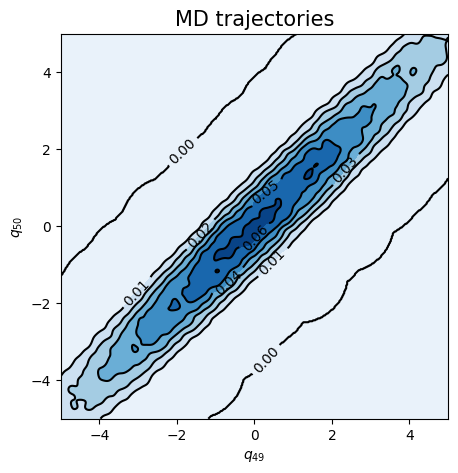

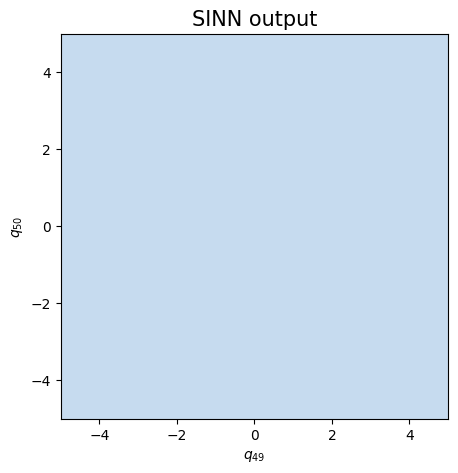

In [75]:
test7(model3)

In [76]:
### Defining SINN model
net4 = SINN(2, 75, 4, 2).to(device) # input dimension, hidden size, number of layers, output dimension
model4 = Model(net=net4)
model4.train()

[0]-th step loss: 0.8668, 0.8562, acf: 0.09664, ccf: 0.13562, pdf: 0.29320, pdf2: 0.29015, acf2: 0.04064
[50]-th step loss: 0.3516, 0.3511, acf: 0.06010, ccf: 0.23778, pdf: 0.01717, pdf2: 0.01646, acf2: 0.01957
[100]-th step loss: 0.4288, 0.4942, acf: 0.01698, ccf: 0.35723, pdf: 0.07564, pdf2: 0.04179, acf2: 0.00259
[150]-th step loss: 0.4103, 0.4111, acf: 0.01061, ccf: 0.37507, pdf: 0.00763, pdf2: 0.01546, acf2: 0.00235
[200]-th step loss: 0.4422, 0.4272, acf: 0.00619, ccf: 0.40096, pdf: 0.00636, pdf2: 0.01306, acf2: 0.00061
[250]-th step loss: 0.3703, 0.3679, acf: 0.01213, ccf: 0.33437, pdf: 0.00662, pdf2: 0.01427, acf2: 0.00048
[300]-th step loss: 0.3792, 0.3796, acf: 0.00822, ccf: 0.34803, pdf: 0.00808, pdf2: 0.01425, acf2: 0.00103
[350]-th step loss: 0.3453, 0.3457, acf: 0.01673, ccf: 0.30697, pdf: 0.00763, pdf2: 0.01420, acf2: 0.00020
[400]-th step loss: 0.3377, 0.3550, acf: 0.01250, ccf: 0.32084, pdf: 0.00747, pdf2: 0.01394, acf2: 0.00026
[450]-th step loss: 0.3592, 0.3560, acf:

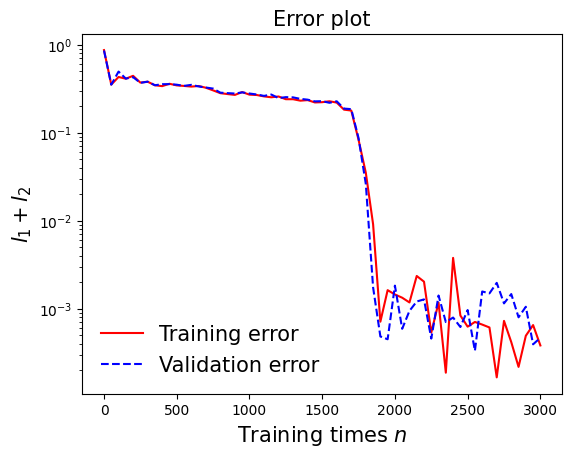

In [77]:
draw_loss(model4)

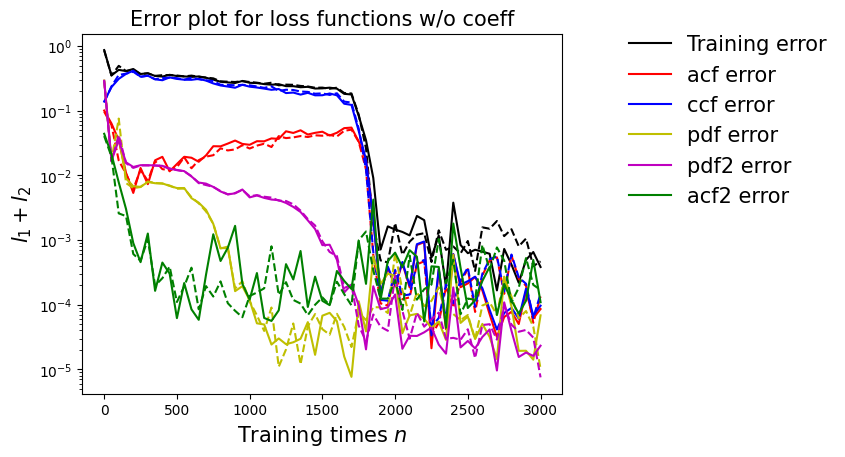

In [78]:
draw_errors(model4)

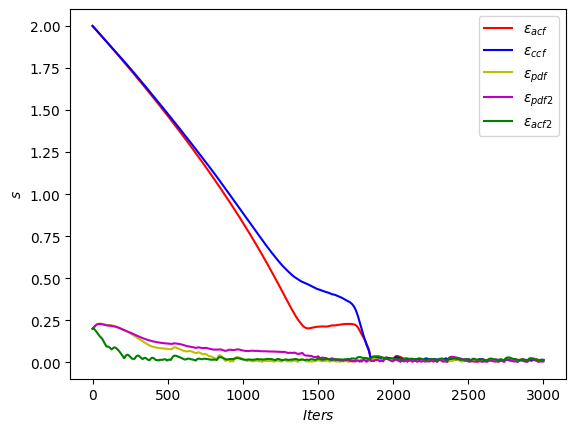

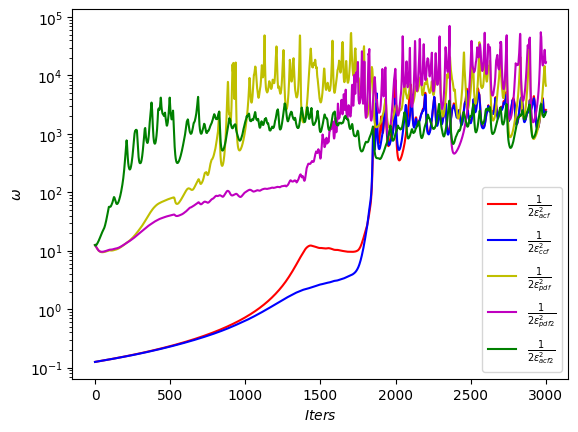

In [79]:
draw_adaptive_w(model4)
draw_epoch_w(model4)

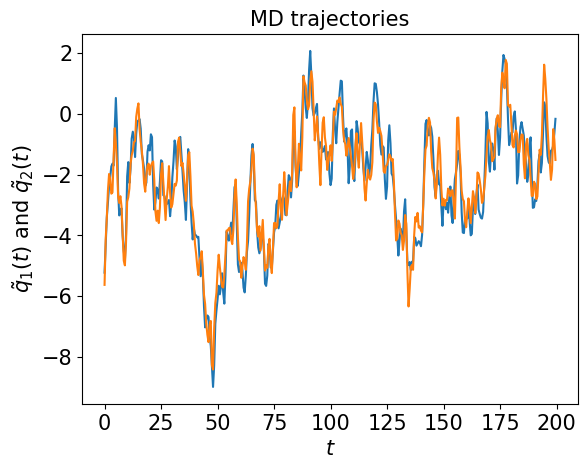

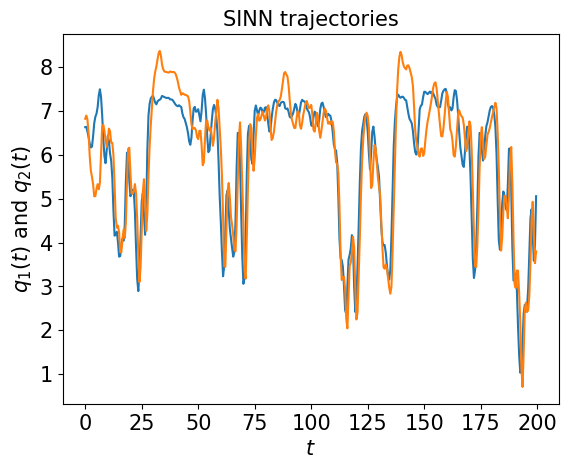

In [80]:
test1(model4)

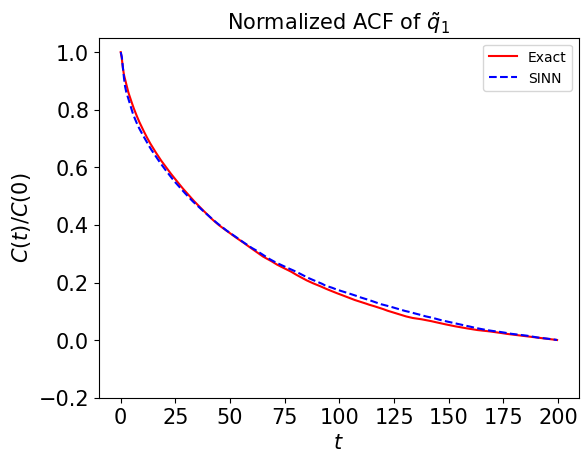

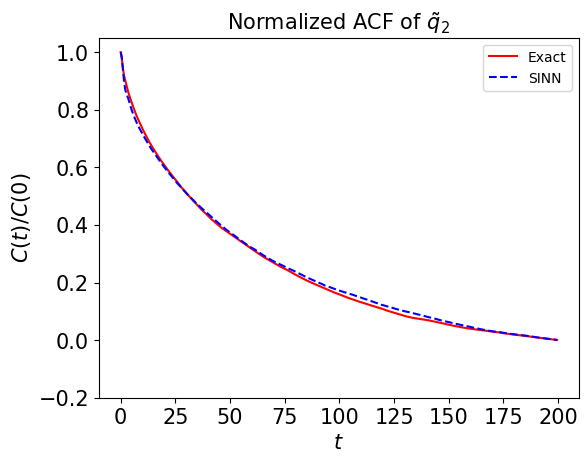

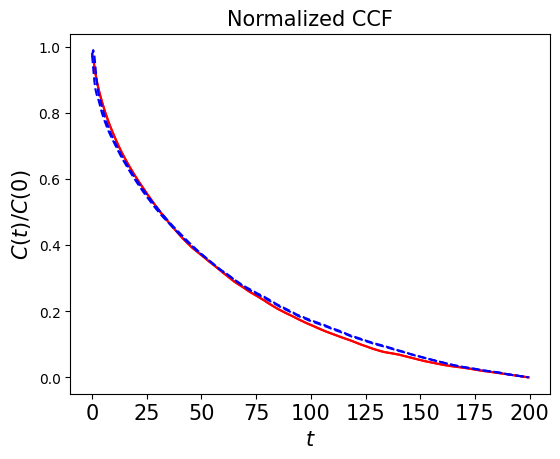

In [81]:
test2(model4)

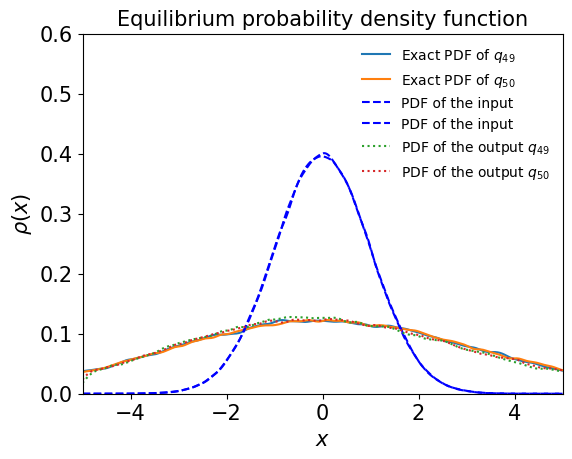

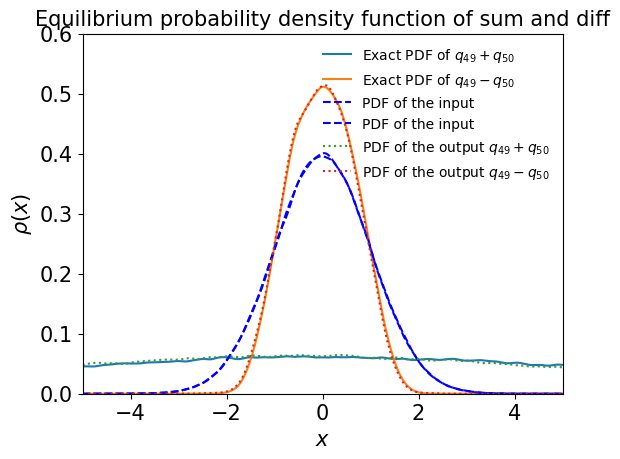

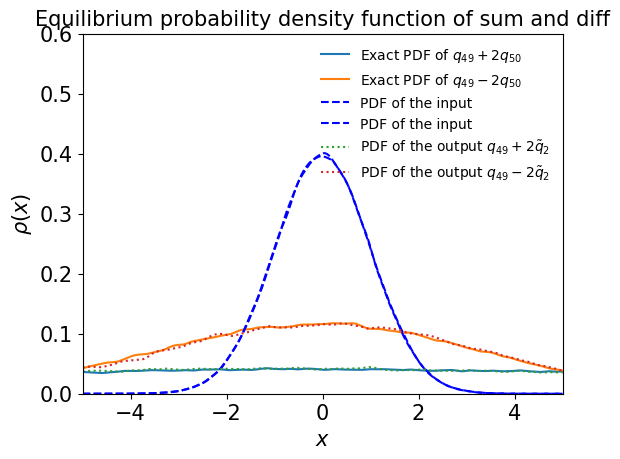

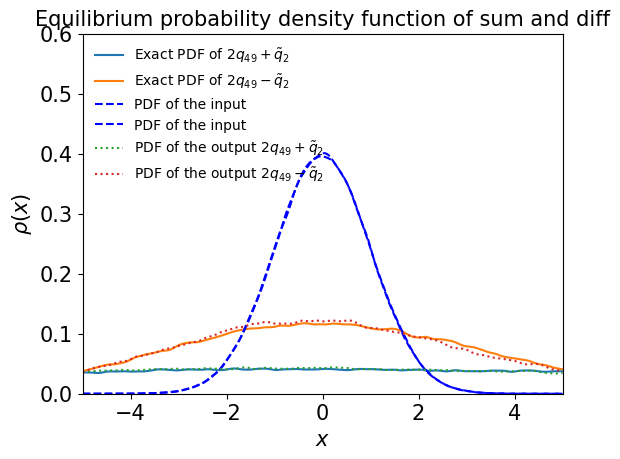

In [82]:
test3(model4)

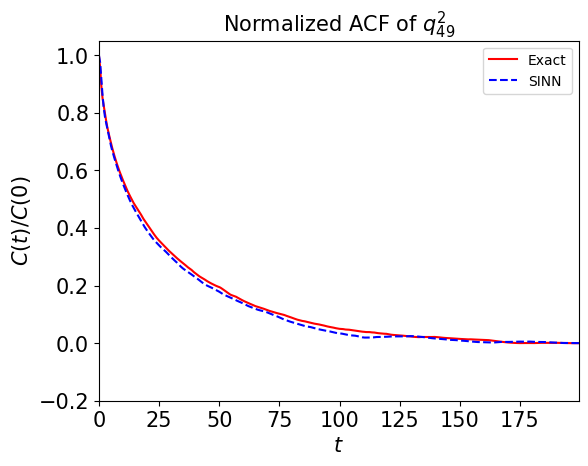

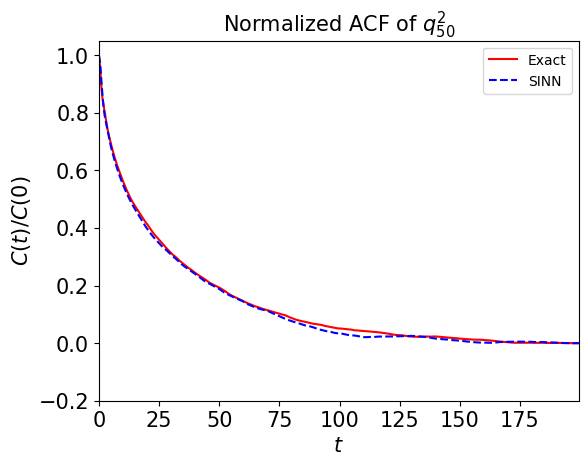

In [83]:
test4(model4)

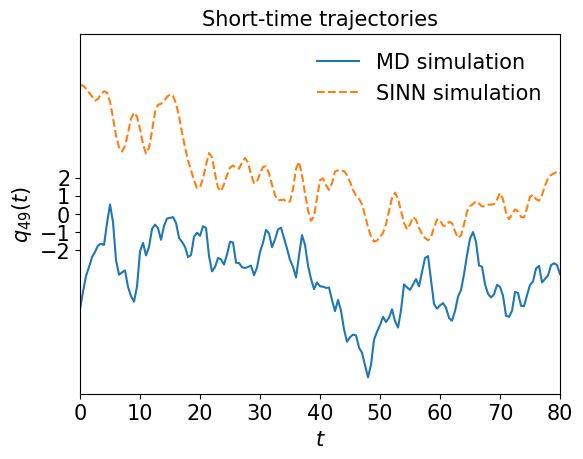

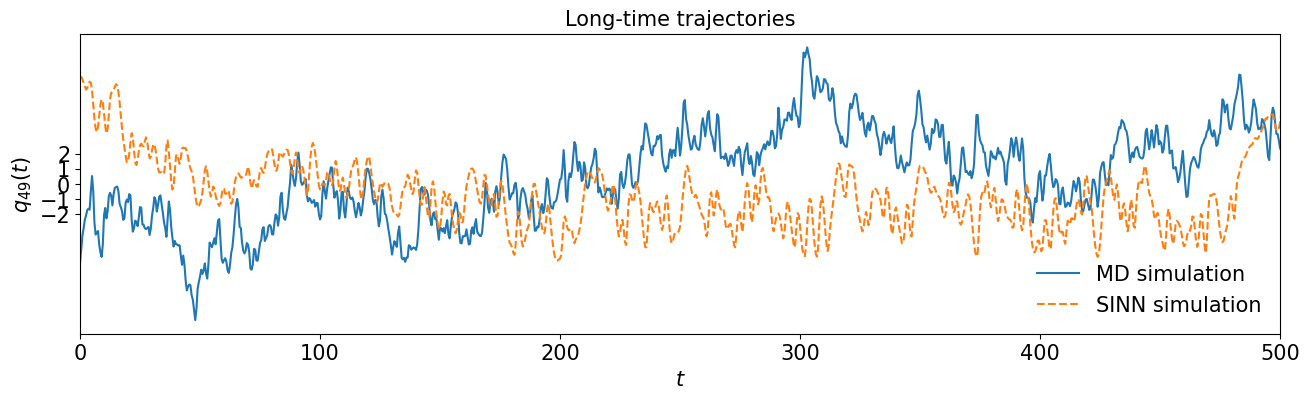

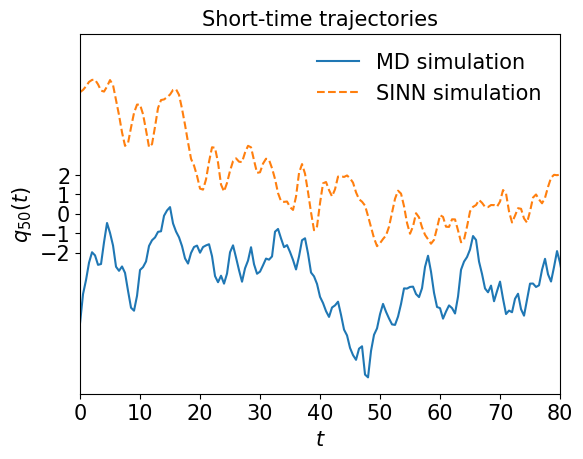

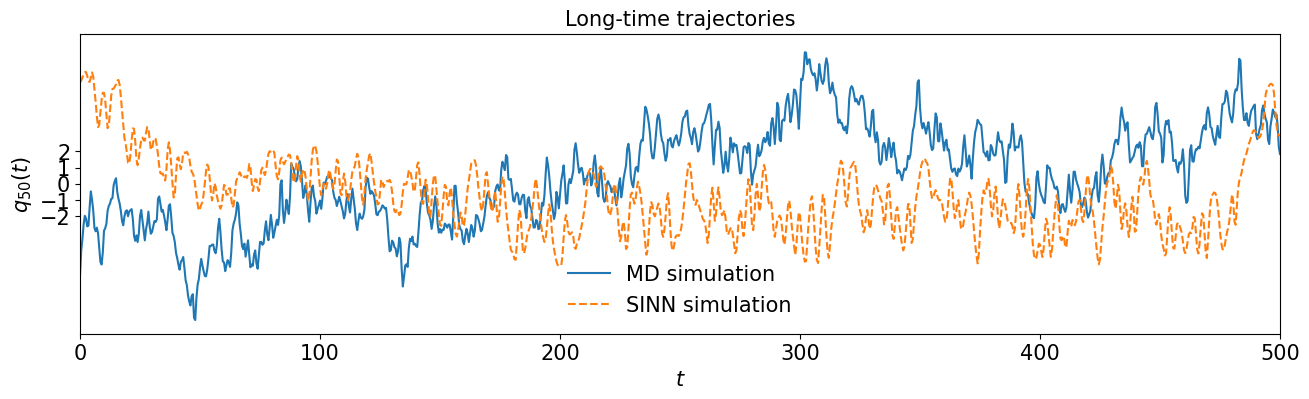

In [84]:
test5(model4)

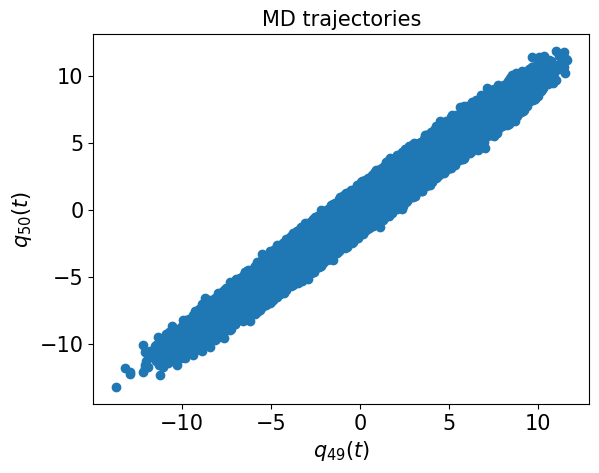

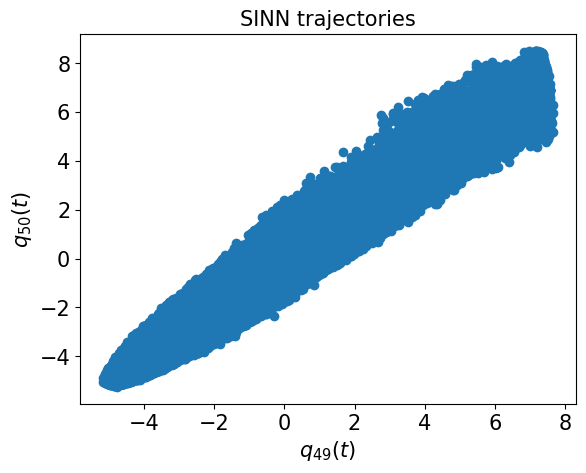

In [85]:
test6(model4)

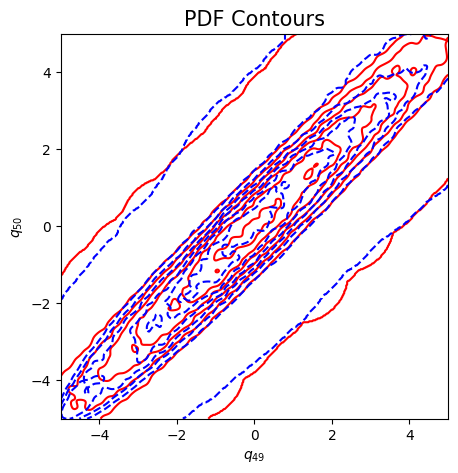

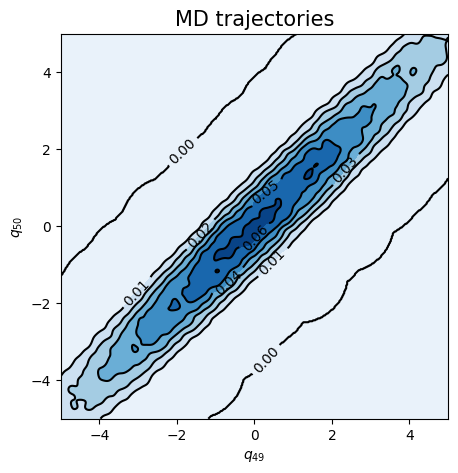

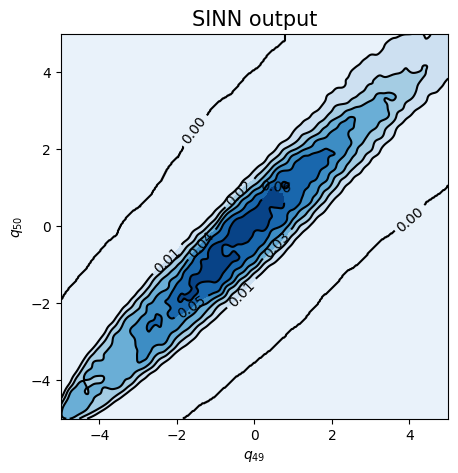

In [86]:
test7(model4)

In [ ]:
### Defining SINN model
net5 = SINN(2, 75, 3, 2).to(device) # input dimension, hidden size, number of layers, output dimension
model5 = Model(net=net5)
model5.train()

In [ ]:
draw_loss(model5)

In [ ]:
draw_errors(model5)

In [ ]:
draw_adaptive_w(model5)
draw_epoch_w(model5)

In [ ]:
test1(model5)

In [ ]:
test2(model5)

In [ ]:
test3(model5)

In [ ]:
test4(model5)

In [ ]:
test5(model5)

In [ ]:
test6(model5)

In [ ]:
test7(model5)

In [ ]:
### Defining SINN model
net6 = SINN(2, 75, 3, 2).to(device) # input dimension, hidden size, number of layers, output dimension
model6 = Model(net=net6)
model6.train()

In [ ]:
draw_loss(model6)

In [ ]:
draw_errors(model6)

In [ ]:
draw_adaptive_w(model6)
draw_epoch_w(model6)

In [ ]:
test1(model6)

In [ ]:
test2(model6)

In [ ]:
test3(model6)

In [ ]:
test4(model6)

In [ ]:
test5(model6)

In [ ]:
test6(model6)

In [ ]:
test7(model6)

In [ ]:
### Defining SINN model
net7 = SINN(2, 75, 3, 2).to(device) # input dimension, hidden size, number of layers, output dimension
model7 = Model(net=net7)
model7.train()

In [ ]:
draw_loss(model7)

In [ ]:
draw_errors(model7)

In [ ]:
draw_adaptive_w(model7)
draw_epoch_w(model7)

In [ ]:
test1(model7)

In [ ]:
test2(model7)

In [ ]:
test3(model7)

In [ ]:
test4(model7)

In [ ]:
test5(model7)

In [ ]:
test6(model7)

In [ ]:
test7(model7)

In [ ]:
### Defining SINN model
net8 = SINN(2, 75, 3, 2).to(device) # input dimension, hidden size, number of layers, output dimension
model8 = Model(net=net8)
model8.train()

In [ ]:
draw_loss(model8)

In [ ]:
draw_errors(model8)

In [ ]:
draw_adaptive_w(model8)
draw_epoch_w(model8)

In [ ]:
test1(model8)

In [ ]:
test2(model8)

In [ ]:
test3(model8)

In [ ]:
test4(model8)

In [ ]:
test5(model8)

In [ ]:
test6(model8)

In [ ]:
test7(model8)

In [ ]:
### Defining SINN model
net9 = SINN(2, 75, 3, 2).to(device) # input dimension, hidden size, number of layers, output dimension
model9 = Model(net=net9)
model9.train()

In [ ]:
draw_loss(model9)

In [ ]:
draw_errors(model9)

In [ ]:
draw_adaptive_w(model9)
draw_epoch_w(model9)

In [ ]:
test1(model9)

In [ ]:
test2(model9)

In [ ]:
test3(model9)

In [ ]:
test4(model9)

In [ ]:
test5(model9)

In [ ]:
test6(model9)

In [ ]:
test7(model9)